In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['roi']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'basal_seg',
    'balance_data'  : False,
    'exclude'       : ['normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_0_0_0_1_normalized_e_n_e_0_0_e_0_0_basal_seg_data_norm_b25_roi_t1_native_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(673340, 1040)
(673340, 3)
validation
(95538, 1040)
(95538, 3)
test
(86036, 1040)
(86036, 3)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 1040)]            0         


 dense (Dense)               (None, 1024)              1065984   


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 3)                 387       


Total params: 1755395 (6.70 MB)


Trainable params: 1755395 (6.70 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/68 [..............................] - ETA: 1:48 - loss: 1.3083 - STD: 0.3718 - MAE: 0.3375

 3/68 [>.............................] - ETA: 1s - loss: 1.0732 - STD: 0.2537 - MAE: 0.3648  

 5/68 [=>............................] - ETA: 1s - loss: 1.0320 - STD: 0.2326 - MAE: 0.3744

 7/68 [==>...........................] - ETA: 1s - loss: 1.0115 - STD: 0.2280 - MAE: 0.3758

 9/68 [==>...........................] - ETA: 1s - loss: 0.9896 - STD: 0.2240 - MAE: 0.3735

11/68 [===>..........................] - ETA: 1s - loss: 0.9737 - STD: 0.2258 - MAE: 0.3699

13/68 [====>.........................] - ETA: 1s - loss: 0.9639 - STD: 0.2284 - MAE: 0.3674

15/68 [=====>........................] - ETA: 1s - loss: 0.9557 - STD: 0.2274 - MAE: 0.3666

17/68 [======>.......................] - ETA: 1s - loss: 0.9481 - STD: 0.2223 - MAE: 0.3672

19/68 [=======>......................] - ETA: 1s - loss: 0.9425 - STD: 0.2162 - MAE: 0.3685

21/68 [========>.....................] - ETA: 1s - loss: 0.9374 - STD: 0.2115 - MAE: 0.3694

23/68 [=========>....................] - ETA: 1s - loss: 0.9323 - STD: 0.2088 - MAE: 0.3695

25/68 [==========>...................] - ETA: 1s - loss: 0.9277 - STD: 0.2078 - MAE: 0.3689

27/68 [==========>...................] - ETA: 1s - loss: 0.9226 - STD: 0.2081 - MAE: 0.3677

29/68 [===========>..................] - ETA: 1s - loss: 0.9180 - STD: 0.2089 - MAE: 0.3662

31/68 [============>.................] - ETA: 0s - loss: 0.9129 - STD: 0.2093 - MAE: 0.3648

33/68 [=============>................] - ETA: 0s - loss: 0.9059 - STD: 0.2089 - MAE: 0.3632

35/68 [==============>...............] - ETA: 0s - loss: 0.8975 - STD: 0.2084 - MAE: 0.3612

37/68 [===============>..............] - ETA: 0s - loss: 0.8871 - STD: 0.2087 - MAE: 0.3583

39/68 [================>.............] - ETA: 0s - loss: 0.8750 - STD: 0.2102 - MAE: 0.3545

41/68 [=================>............] - ETA: 0s - loss: 0.8609 - STD: 0.2125 - MAE: 0.3498

43/68 [=================>............] - ETA: 0s - loss: 0.8453 - STD: 0.2159 - MAE: 0.3442

45/68 [==================>...........] - ETA: 0s - loss: 0.8290 - STD: 0.2208 - MAE: 0.3376

47/68 [===================>..........] - ETA: 0s - loss: 0.8131 - STD: 0.2263 - MAE: 0.3309

49/68 [====================>.........] - ETA: 0s - loss: 0.7974 - STD: 0.2320 - MAE: 0.3240

51/68 [=====================>........] - ETA: 0s - loss: 0.7823 - STD: 0.2379 - MAE: 0.3171

53/68 [======================>.......] - ETA: 0s - loss: 0.7682 - STD: 0.2436 - MAE: 0.3105

55/68 [=======================>......] - ETA: 0s - loss: 0.7547 - STD: 0.2491 - MAE: 0.3042

57/68 [========================>.....] - ETA: 0s - loss: 0.7417 - STD: 0.2542 - MAE: 0.2982

59/68 [=========================>....] - ETA: 0s - loss: 0.7296 - STD: 0.2589 - MAE: 0.2927

61/68 [=========================>....] - ETA: 0s - loss: 0.7181 - STD: 0.2634 - MAE: 0.2875

63/68 [==========================>...] - ETA: 0s - loss: 0.7064 - STD: 0.2675 - MAE: 0.2824

65/68 [===========================>..] - ETA: 0s - loss: 0.6991 - STD: 0.2712 - MAE: 0.2779

67/68 [============================>.] - ETA: 0s - loss: 0.6885 - STD: 0.2747 - MAE: 0.2736

68/68 [==============================] - 5s 51ms/step - loss: 0.6833 - STD: 0.2763 - MAE: 0.2715 - val_loss: 0.3027 - val_STD: 0.3847 - val_MAE: 0.1237


Epoch 2/10000


 1/68 [..............................] - ETA: 3s - loss: 0.3420 - STD: 0.3859 - MAE: 0.1326

 3/68 [>.............................] - ETA: 1s - loss: 0.3390 - STD: 0.3880 - MAE: 0.1305

 5/68 [=>............................] - ETA: 1s - loss: 0.3329 - STD: 0.3912 - MAE: 0.1270

 7/68 [==>...........................] - ETA: 1s - loss: 0.3315 - STD: 0.3944 - MAE: 0.1245

 9/68 [==>...........................] - ETA: 1s - loss: 0.3286 - STD: 0.3957 - MAE: 0.1230

11/68 [===>..........................] - ETA: 1s - loss: 0.3257 - STD: 0.3964 - MAE: 0.1219

13/68 [====>.........................] - ETA: 1s - loss: 0.3236 - STD: 0.3963 - MAE: 0.1216

15/68 [=====>........................] - ETA: 1s - loss: 0.3208 - STD: 0.3962 - MAE: 0.1211

17/68 [======>.......................] - ETA: 1s - loss: 0.3191 - STD: 0.3968 - MAE: 0.1204

19/68 [=======>......................] - ETA: 1s - loss: 0.3166 - STD: 0.3974 - MAE: 0.1194

21/68 [========>.....................] - ETA: 1s - loss: 0.3138 - STD: 0.3983 - MAE: 0.1182

23/68 [=========>....................] - ETA: 1s - loss: 0.3113 - STD: 0.3989 - MAE: 0.1173

25/68 [==========>...................] - ETA: 1s - loss: 0.3083 - STD: 0.3992 - MAE: 0.1165

27/68 [==========>...................] - ETA: 1s - loss: 0.3066 - STD: 0.3998 - MAE: 0.1157

29/68 [===========>..................] - ETA: 1s - loss: 0.3046 - STD: 0.4005 - MAE: 0.1148

31/68 [============>.................] - ETA: 0s - loss: 0.3021 - STD: 0.4011 - MAE: 0.1139

33/68 [=============>................] - ETA: 0s - loss: 0.3001 - STD: 0.4015 - MAE: 0.1131

35/68 [==============>...............] - ETA: 0s - loss: 0.2982 - STD: 0.4022 - MAE: 0.1123

37/68 [===============>..............] - ETA: 0s - loss: 0.2960 - STD: 0.4029 - MAE: 0.1113

39/68 [================>.............] - ETA: 0s - loss: 0.2936 - STD: 0.4034 - MAE: 0.1104

41/68 [=================>............] - ETA: 0s - loss: 0.2914 - STD: 0.4039 - MAE: 0.1096

43/68 [=================>............] - ETA: 0s - loss: 0.2897 - STD: 0.4046 - MAE: 0.1088

45/68 [==================>...........] - ETA: 0s - loss: 0.2878 - STD: 0.4052 - MAE: 0.1080

48/68 [====================>.........] - ETA: 0s - loss: 0.2852 - STD: 0.4059 - MAE: 0.1068

50/68 [=====================>........] - ETA: 0s - loss: 0.2831 - STD: 0.4065 - MAE: 0.1059

52/68 [=====================>........] - ETA: 0s - loss: 0.2808 - STD: 0.4071 - MAE: 0.1050

54/68 [======================>.......] - ETA: 0s - loss: 0.2786 - STD: 0.4077 - MAE: 0.1042

56/68 [=======================>......] - ETA: 0s - loss: 0.2766 - STD: 0.4083 - MAE: 0.1033

58/68 [========================>.....] - ETA: 0s - loss: 0.2746 - STD: 0.4088 - MAE: 0.1025

60/68 [=========================>....] - ETA: 0s - loss: 0.2727 - STD: 0.4094 - MAE: 0.1017

62/68 [==========================>...] - ETA: 0s - loss: 0.2704 - STD: 0.4100 - MAE: 0.1007

64/68 [===========================>..] - ETA: 0s - loss: 0.2681 - STD: 0.4105 - MAE: 0.0999

66/68 [============================>.] - ETA: 0s - loss: 0.2660 - STD: 0.4111 - MAE: 0.0990

68/68 [==============================] - ETA: 0s - loss: 0.2638 - STD: 0.4117 - MAE: 0.0982

68/68 [==============================] - 2s 30ms/step - loss: 0.2638 - STD: 0.4117 - MAE: 0.0982 - val_loss: 0.1847 - val_STD: 0.4280 - val_MAE: 0.0702


Epoch 3/10000


 1/68 [..............................] - ETA: 3s - loss: 0.1881 - STD: 0.4280 - MAE: 0.0713

 3/68 [>.............................] - ETA: 1s - loss: 0.1942 - STD: 0.4289 - MAE: 0.0720

 5/68 [=>............................] - ETA: 1s - loss: 0.1897 - STD: 0.4292 - MAE: 0.0710

 7/68 [==>...........................] - ETA: 1s - loss: 0.1905 - STD: 0.4296 - MAE: 0.0708

 9/68 [==>...........................] - ETA: 1s - loss: 0.1881 - STD: 0.4296 - MAE: 0.0703

11/68 [===>..........................] - ETA: 1s - loss: 0.1874 - STD: 0.4302 - MAE: 0.0698

13/68 [====>.........................] - ETA: 1s - loss: 0.1870 - STD: 0.4304 - MAE: 0.0696

15/68 [=====>........................] - ETA: 1s - loss: 0.1848 - STD: 0.4311 - MAE: 0.0686

17/68 [======>.......................] - ETA: 1s - loss: 0.1845 - STD: 0.4312 - MAE: 0.0686

19/68 [=======>......................] - ETA: 1s - loss: 0.1827 - STD: 0.4317 - MAE: 0.0678

21/68 [========>.....................] - ETA: 1s - loss: 0.1819 - STD: 0.4319 - MAE: 0.0675

23/68 [=========>....................] - ETA: 1s - loss: 0.1809 - STD: 0.4324 - MAE: 0.0669

25/68 [==========>...................] - ETA: 1s - loss: 0.1801 - STD: 0.4326 - MAE: 0.0666

27/68 [==========>...................] - ETA: 1s - loss: 0.1788 - STD: 0.4329 - MAE: 0.0661

29/68 [===========>..................] - ETA: 1s - loss: 0.1778 - STD: 0.4332 - MAE: 0.0657

31/68 [============>.................] - ETA: 0s - loss: 0.1768 - STD: 0.4334 - MAE: 0.0654

33/68 [=============>................] - ETA: 0s - loss: 0.1758 - STD: 0.4337 - MAE: 0.0649

35/68 [==============>...............] - ETA: 0s - loss: 0.1747 - STD: 0.4338 - MAE: 0.0647

37/68 [===============>..............] - ETA: 0s - loss: 0.1740 - STD: 0.4341 - MAE: 0.0643

39/68 [================>.............] - ETA: 0s - loss: 0.1734 - STD: 0.4342 - MAE: 0.0641

41/68 [=================>............] - ETA: 0s - loss: 0.1731 - STD: 0.4345 - MAE: 0.0638

43/68 [=================>............] - ETA: 0s - loss: 0.1725 - STD: 0.4346 - MAE: 0.0637

46/68 [===================>..........] - ETA: 0s - loss: 0.1719 - STD: 0.4348 - MAE: 0.0634

48/68 [====================>.........] - ETA: 0s - loss: 0.1714 - STD: 0.4350 - MAE: 0.0631

50/68 [=====================>........] - ETA: 0s - loss: 0.1707 - STD: 0.4351 - MAE: 0.0629

52/68 [=====================>........] - ETA: 0s - loss: 0.1702 - STD: 0.4352 - MAE: 0.0627

54/68 [======================>.......] - ETA: 0s - loss: 0.1698 - STD: 0.4354 - MAE: 0.0625

56/68 [=======================>......] - ETA: 0s - loss: 0.1692 - STD: 0.4354 - MAE: 0.0624

58/68 [========================>.....] - ETA: 0s - loss: 0.1686 - STD: 0.4357 - MAE: 0.0621

60/68 [=========================>....] - ETA: 0s - loss: 0.1682 - STD: 0.4357 - MAE: 0.0621

62/68 [==========================>...] - ETA: 0s - loss: 0.1675 - STD: 0.4358 - MAE: 0.0618

64/68 [===========================>..] - ETA: 0s - loss: 0.1670 - STD: 0.4359 - MAE: 0.0616

66/68 [============================>.] - ETA: 0s - loss: 0.1665 - STD: 0.4360 - MAE: 0.0615

68/68 [==============================] - ETA: 0s - loss: 0.1660 - STD: 0.4361 - MAE: 0.0613

68/68 [==============================] - 2s 30ms/step - loss: 0.1660 - STD: 0.4361 - MAE: 0.0613 - val_loss: 0.1454 - val_STD: 0.4405 - val_MAE: 0.0536


Epoch 4/10000


 1/68 [..............................] - ETA: 4s - loss: 0.1489 - STD: 0.4388 - MAE: 0.0564

 3/68 [>.............................] - ETA: 1s - loss: 0.1499 - STD: 0.4408 - MAE: 0.0547

 5/68 [=>............................] - ETA: 1s - loss: 0.1469 - STD: 0.4401 - MAE: 0.0548

 7/68 [==>...........................] - ETA: 1s - loss: 0.1475 - STD: 0.4407 - MAE: 0.0543

 9/68 [==>...........................] - ETA: 1s - loss: 0.1459 - STD: 0.4403 - MAE: 0.0544

11/68 [===>..........................] - ETA: 1s - loss: 0.1466 - STD: 0.4404 - MAE: 0.0545

13/68 [====>.........................] - ETA: 1s - loss: 0.1457 - STD: 0.4409 - MAE: 0.0539

15/68 [=====>........................] - ETA: 1s - loss: 0.1453 - STD: 0.4408 - MAE: 0.0539

17/68 [======>.......................] - ETA: 1s - loss: 0.1453 - STD: 0.4411 - MAE: 0.0536

19/68 [=======>......................] - ETA: 1s - loss: 0.1446 - STD: 0.4412 - MAE: 0.0534

21/68 [========>.....................] - ETA: 1s - loss: 0.1453 - STD: 0.4412 - MAE: 0.0535

23/68 [=========>....................] - ETA: 1s - loss: 0.1448 - STD: 0.4414 - MAE: 0.0533

25/68 [==========>...................] - ETA: 1s - loss: 0.1447 - STD: 0.4413 - MAE: 0.0533

27/68 [==========>...................] - ETA: 1s - loss: 0.1443 - STD: 0.4414 - MAE: 0.0532

29/68 [===========>..................] - ETA: 1s - loss: 0.1435 - STD: 0.4414 - MAE: 0.0531

31/68 [============>.................] - ETA: 0s - loss: 0.1434 - STD: 0.4415 - MAE: 0.0530

34/68 [==============>...............] - ETA: 0s - loss: 0.1435 - STD: 0.4415 - MAE: 0.0530

36/68 [==============>...............] - ETA: 0s - loss: 0.1435 - STD: 0.4417 - MAE: 0.0528

38/68 [===============>..............] - ETA: 0s - loss: 0.1435 - STD: 0.4417 - MAE: 0.0528

40/68 [================>.............] - ETA: 0s - loss: 0.1433 - STD: 0.4417 - MAE: 0.0528

42/68 [=================>............] - ETA: 0s - loss: 0.1432 - STD: 0.4418 - MAE: 0.0527

44/68 [==================>...........] - ETA: 0s - loss: 0.1432 - STD: 0.4418 - MAE: 0.0527

46/68 [===================>..........] - ETA: 0s - loss: 0.1433 - STD: 0.4418 - MAE: 0.0527

48/68 [====================>.........] - ETA: 0s - loss: 0.1434 - STD: 0.4419 - MAE: 0.0527

50/68 [=====================>........] - ETA: 0s - loss: 0.1433 - STD: 0.4419 - MAE: 0.0526

52/68 [=====================>........] - ETA: 0s - loss: 0.1434 - STD: 0.4421 - MAE: 0.0525

54/68 [======================>.......] - ETA: 0s - loss: 0.1433 - STD: 0.4420 - MAE: 0.0525

56/68 [=======================>......] - ETA: 0s - loss: 0.1428 - STD: 0.4422 - MAE: 0.0523

58/68 [========================>.....] - ETA: 0s - loss: 0.1427 - STD: 0.4422 - MAE: 0.0523

60/68 [=========================>....] - ETA: 0s - loss: 0.1424 - STD: 0.4422 - MAE: 0.0522

62/68 [==========================>...] - ETA: 0s - loss: 0.1421 - STD: 0.4423 - MAE: 0.0521

64/68 [===========================>..] - ETA: 0s - loss: 0.1420 - STD: 0.4423 - MAE: 0.0520

66/68 [============================>.] - ETA: 0s - loss: 0.1418 - STD: 0.4423 - MAE: 0.0520

68/68 [==============================] - ETA: 0s - loss: 0.1416 - STD: 0.4424 - MAE: 0.0519

68/68 [==============================] - 2s 31ms/step - loss: 0.1416 - STD: 0.4424 - MAE: 0.0519 - val_loss: 0.1329 - val_STD: 0.4474 - val_MAE: 0.0454


Epoch 5/10000


 1/68 [..............................] - ETA: 3s - loss: 0.1310 - STD: 0.4442 - MAE: 0.0481

 3/68 [>.............................] - ETA: 1s - loss: 0.1288 - STD: 0.4434 - MAE: 0.0484

 5/68 [=>............................] - ETA: 1s - loss: 0.1297 - STD: 0.4436 - MAE: 0.0486

 7/68 [==>...........................] - ETA: 1s - loss: 0.1313 - STD: 0.4433 - MAE: 0.0493

 9/68 [==>...........................] - ETA: 1s - loss: 0.1307 - STD: 0.4437 - MAE: 0.0489

11/68 [===>..........................] - ETA: 1s - loss: 0.1300 - STD: 0.4436 - MAE: 0.0488

13/68 [====>.........................] - ETA: 1s - loss: 0.1300 - STD: 0.4438 - MAE: 0.0487

15/68 [=====>........................] - ETA: 1s - loss: 0.1304 - STD: 0.4438 - MAE: 0.0487

17/68 [======>.......................] - ETA: 1s - loss: 0.1301 - STD: 0.4440 - MAE: 0.0486

19/68 [=======>......................] - ETA: 1s - loss: 0.1303 - STD: 0.4440 - MAE: 0.0486

21/68 [========>.....................] - ETA: 1s - loss: 0.1310 - STD: 0.4442 - MAE: 0.0485

23/68 [=========>....................] - ETA: 1s - loss: 0.1312 - STD: 0.4442 - MAE: 0.0486

25/68 [==========>...................] - ETA: 1s - loss: 0.1314 - STD: 0.4442 - MAE: 0.0486

27/68 [==========>...................] - ETA: 1s - loss: 0.1314 - STD: 0.4443 - MAE: 0.0486

29/68 [===========>..................] - ETA: 1s - loss: 0.1314 - STD: 0.4442 - MAE: 0.0486

31/68 [============>.................] - ETA: 0s - loss: 0.1315 - STD: 0.4443 - MAE: 0.0486

33/68 [=============>................] - ETA: 0s - loss: 0.1313 - STD: 0.4442 - MAE: 0.0486

35/68 [==============>...............] - ETA: 0s - loss: 0.1315 - STD: 0.4441 - MAE: 0.0487

37/68 [===============>..............] - ETA: 0s - loss: 0.1318 - STD: 0.4442 - MAE: 0.0487

39/68 [================>.............] - ETA: 0s - loss: 0.1321 - STD: 0.4441 - MAE: 0.0489

41/68 [=================>............] - ETA: 0s - loss: 0.1321 - STD: 0.4441 - MAE: 0.0489

43/68 [=================>............] - ETA: 0s - loss: 0.1319 - STD: 0.4441 - MAE: 0.0488

45/68 [==================>...........] - ETA: 0s - loss: 0.1320 - STD: 0.4441 - MAE: 0.0489

47/68 [===================>..........] - ETA: 0s - loss: 0.1317 - STD: 0.4442 - MAE: 0.0488

49/68 [====================>.........] - ETA: 0s - loss: 0.1316 - STD: 0.4442 - MAE: 0.0487

51/68 [=====================>........] - ETA: 0s - loss: 0.1315 - STD: 0.4442 - MAE: 0.0487

53/68 [======================>.......] - ETA: 0s - loss: 0.1314 - STD: 0.4443 - MAE: 0.0486

55/68 [=======================>......] - ETA: 0s - loss: 0.1314 - STD: 0.4443 - MAE: 0.0486

57/68 [========================>.....] - ETA: 0s - loss: 0.1313 - STD: 0.4444 - MAE: 0.0485

59/68 [=========================>....] - ETA: 0s - loss: 0.1312 - STD: 0.4444 - MAE: 0.0485

61/68 [=========================>....] - ETA: 0s - loss: 0.1309 - STD: 0.4444 - MAE: 0.0484

63/68 [==========================>...] - ETA: 0s - loss: 0.1309 - STD: 0.4445 - MAE: 0.0484

65/68 [===========================>..] - ETA: 0s - loss: 0.1307 - STD: 0.4445 - MAE: 0.0483

68/68 [==============================] - ETA: 0s - loss: 0.1306 - STD: 0.4445 - MAE: 0.0483

68/68 [==============================] - 2s 30ms/step - loss: 0.1306 - STD: 0.4445 - MAE: 0.0483 - val_loss: 0.1316 - val_STD: 0.4504 - val_MAE: 0.0426


Epoch 6/10000


 1/68 [..............................] - ETA: 4s - loss: 0.1429 - STD: 0.4461 - MAE: 0.0491

 3/68 [>.............................] - ETA: 1s - loss: 0.1330 - STD: 0.4453 - MAE: 0.0481

 5/68 [=>............................] - ETA: 1s - loss: 0.1339 - STD: 0.4452 - MAE: 0.0484

 7/68 [==>...........................] - ETA: 1s - loss: 0.1330 - STD: 0.4455 - MAE: 0.0479

 9/68 [==>...........................] - ETA: 1s - loss: 0.1304 - STD: 0.4452 - MAE: 0.0476

11/68 [===>..........................] - ETA: 1s - loss: 0.1289 - STD: 0.4458 - MAE: 0.0468

13/68 [====>.........................] - ETA: 1s - loss: 0.1300 - STD: 0.4457 - MAE: 0.0472

15/68 [=====>........................] - ETA: 1s - loss: 0.1300 - STD: 0.4457 - MAE: 0.0472

17/68 [======>.......................] - ETA: 1s - loss: 0.1297 - STD: 0.4459 - MAE: 0.0470

19/68 [=======>......................] - ETA: 1s - loss: 0.1284 - STD: 0.4458 - MAE: 0.0468

21/68 [========>.....................] - ETA: 1s - loss: 0.1280 - STD: 0.4458 - MAE: 0.0467

23/68 [=========>....................] - ETA: 1s - loss: 0.1276 - STD: 0.4458 - MAE: 0.0467

26/68 [==========>...................] - ETA: 1s - loss: 0.1277 - STD: 0.4457 - MAE: 0.0467

28/68 [===========>..................] - ETA: 1s - loss: 0.1276 - STD: 0.4457 - MAE: 0.0468

30/68 [============>.................] - ETA: 0s - loss: 0.1277 - STD: 0.4457 - MAE: 0.0468

32/68 [=============>................] - ETA: 0s - loss: 0.1270 - STD: 0.4456 - MAE: 0.0467

34/68 [==============>...............] - ETA: 0s - loss: 0.1266 - STD: 0.4457 - MAE: 0.0466

36/68 [==============>...............] - ETA: 0s - loss: 0.1265 - STD: 0.4457 - MAE: 0.0466

38/68 [===============>..............] - ETA: 0s - loss: 0.1262 - STD: 0.4457 - MAE: 0.0465

40/68 [================>.............] - ETA: 0s - loss: 0.1261 - STD: 0.4457 - MAE: 0.0465

42/68 [=================>............] - ETA: 0s - loss: 0.1258 - STD: 0.4457 - MAE: 0.0465

44/68 [==================>...........] - ETA: 0s - loss: 0.1255 - STD: 0.4457 - MAE: 0.0464

46/68 [===================>..........] - ETA: 0s - loss: 0.1255 - STD: 0.4457 - MAE: 0.0464

48/68 [====================>.........] - ETA: 0s - loss: 0.1256 - STD: 0.4458 - MAE: 0.0464

50/68 [=====================>........] - ETA: 0s - loss: 0.1252 - STD: 0.4458 - MAE: 0.0463

52/68 [=====================>........] - ETA: 0s - loss: 0.1250 - STD: 0.4458 - MAE: 0.0462

54/68 [======================>.......] - ETA: 0s - loss: 0.1247 - STD: 0.4459 - MAE: 0.0462

56/68 [=======================>......] - ETA: 0s - loss: 0.1246 - STD: 0.4459 - MAE: 0.0461

58/68 [========================>.....] - ETA: 0s - loss: 0.1247 - STD: 0.4459 - MAE: 0.0461

60/68 [=========================>....] - ETA: 0s - loss: 0.1246 - STD: 0.4460 - MAE: 0.0460

62/68 [==========================>...] - ETA: 0s - loss: 0.1246 - STD: 0.4460 - MAE: 0.0461

64/68 [===========================>..] - ETA: 0s - loss: 0.1246 - STD: 0.4460 - MAE: 0.0460

66/68 [============================>.] - ETA: 0s - loss: 0.1246 - STD: 0.4460 - MAE: 0.0460

68/68 [==============================] - ETA: 0s - loss: 0.1245 - STD: 0.4460 - MAE: 0.0460

68/68 [==============================] - 2s 30ms/step - loss: 0.1245 - STD: 0.4460 - MAE: 0.0460 - val_loss: 0.1298 - val_STD: 0.4488 - val_MAE: 0.0442


Epoch 7/10000


 1/68 [..............................] - ETA: 3s - loss: 0.1264 - STD: 0.4461 - MAE: 0.0461

 3/68 [>.............................] - ETA: 1s - loss: 0.1286 - STD: 0.4461 - MAE: 0.0467

 5/68 [=>............................] - ETA: 1s - loss: 0.1262 - STD: 0.4468 - MAE: 0.0458

 7/68 [==>...........................] - ETA: 1s - loss: 0.1244 - STD: 0.4465 - MAE: 0.0457

 9/68 [==>...........................] - ETA: 1s - loss: 0.1245 - STD: 0.4466 - MAE: 0.0456

11/68 [===>..........................] - ETA: 1s - loss: 0.1245 - STD: 0.4464 - MAE: 0.0457

13/68 [====>.........................] - ETA: 1s - loss: 0.1236 - STD: 0.4463 - MAE: 0.0457

15/68 [=====>........................] - ETA: 1s - loss: 0.1234 - STD: 0.4465 - MAE: 0.0454

17/68 [======>.......................] - ETA: 1s - loss: 0.1227 - STD: 0.4464 - MAE: 0.0454

19/68 [=======>......................] - ETA: 1s - loss: 0.1229 - STD: 0.4464 - MAE: 0.0455

22/68 [========>.....................] - ETA: 1s - loss: 0.1230 - STD: 0.4464 - MAE: 0.0455

24/68 [=========>....................] - ETA: 1s - loss: 0.1231 - STD: 0.4464 - MAE: 0.0455

26/68 [==========>...................] - ETA: 1s - loss: 0.1227 - STD: 0.4464 - MAE: 0.0454

28/68 [===========>..................] - ETA: 1s - loss: 0.1219 - STD: 0.4466 - MAE: 0.0451

30/68 [============>.................] - ETA: 0s - loss: 0.1223 - STD: 0.4466 - MAE: 0.0452

32/68 [=============>................] - ETA: 0s - loss: 0.1226 - STD: 0.4466 - MAE: 0.0452

34/68 [==============>...............] - ETA: 0s - loss: 0.1225 - STD: 0.4468 - MAE: 0.0450

36/68 [==============>...............] - ETA: 0s - loss: 0.1228 - STD: 0.4467 - MAE: 0.0452

38/68 [===============>..............] - ETA: 0s - loss: 0.1230 - STD: 0.4467 - MAE: 0.0452

40/68 [================>.............] - ETA: 0s - loss: 0.1230 - STD: 0.4467 - MAE: 0.0452

42/68 [=================>............] - ETA: 0s - loss: 0.1228 - STD: 0.4467 - MAE: 0.0452

44/68 [==================>...........] - ETA: 0s - loss: 0.1229 - STD: 0.4468 - MAE: 0.0451

46/68 [===================>..........] - ETA: 0s - loss: 0.1227 - STD: 0.4468 - MAE: 0.0451

48/68 [====================>.........] - ETA: 0s - loss: 0.1225 - STD: 0.4468 - MAE: 0.0451

50/68 [=====================>........] - ETA: 0s - loss: 0.1225 - STD: 0.4468 - MAE: 0.0451

52/68 [=====================>........] - ETA: 0s - loss: 0.1225 - STD: 0.4467 - MAE: 0.0451

54/68 [======================>.......] - ETA: 0s - loss: 0.1224 - STD: 0.4467 - MAE: 0.0451

56/68 [=======================>......] - ETA: 0s - loss: 0.1224 - STD: 0.4467 - MAE: 0.0451

58/68 [========================>.....] - ETA: 0s - loss: 0.1221 - STD: 0.4467 - MAE: 0.0451

60/68 [=========================>....] - ETA: 0s - loss: 0.1219 - STD: 0.4467 - MAE: 0.0450

62/68 [==========================>...] - ETA: 0s - loss: 0.1218 - STD: 0.4467 - MAE: 0.0450

64/68 [===========================>..] - ETA: 0s - loss: 0.1217 - STD: 0.4467 - MAE: 0.0450

66/68 [============================>.] - ETA: 0s - loss: 0.1215 - STD: 0.4467 - MAE: 0.0450

68/68 [==============================] - ETA: 0s - loss: 0.1214 - STD: 0.4468 - MAE: 0.0449

68/68 [==============================] - 2s 30ms/step - loss: 0.1214 - STD: 0.4468 - MAE: 0.0449 - val_loss: 0.1400 - val_STD: 0.4471 - val_MAE: 0.0481


Epoch 8/10000


 1/68 [..............................] - ETA: 3s - loss: 0.1216 - STD: 0.4451 - MAE: 0.0467

 3/68 [>.............................] - ETA: 1s - loss: 0.1208 - STD: 0.4482 - MAE: 0.0436

 5/68 [=>............................] - ETA: 1s - loss: 0.1232 - STD: 0.4478 - MAE: 0.0446

 7/68 [==>...........................] - ETA: 1s - loss: 0.1218 - STD: 0.4478 - MAE: 0.0442

 9/68 [==>...........................] - ETA: 1s - loss: 0.1203 - STD: 0.4478 - MAE: 0.0438

11/68 [===>..........................] - ETA: 1s - loss: 0.1203 - STD: 0.4478 - MAE: 0.0439

13/68 [====>.........................] - ETA: 1s - loss: 0.1200 - STD: 0.4478 - MAE: 0.0438

15/68 [=====>........................] - ETA: 1s - loss: 0.1200 - STD: 0.4477 - MAE: 0.0439

17/68 [======>.......................] - ETA: 1s - loss: 0.1190 - STD: 0.4478 - MAE: 0.0436

19/68 [=======>......................] - ETA: 1s - loss: 0.1190 - STD: 0.4476 - MAE: 0.0437

21/68 [========>.....................] - ETA: 1s - loss: 0.1192 - STD: 0.4477 - MAE: 0.0437

23/68 [=========>....................] - ETA: 1s - loss: 0.1194 - STD: 0.4475 - MAE: 0.0440

25/68 [==========>...................] - ETA: 1s - loss: 0.1189 - STD: 0.4475 - MAE: 0.0438

27/68 [==========>...................] - ETA: 1s - loss: 0.1191 - STD: 0.4474 - MAE: 0.0439

29/68 [===========>..................] - ETA: 1s - loss: 0.1188 - STD: 0.4474 - MAE: 0.0439

31/68 [============>.................] - ETA: 0s - loss: 0.1186 - STD: 0.4474 - MAE: 0.0439

33/68 [=============>................] - ETA: 0s - loss: 0.1184 - STD: 0.4475 - MAE: 0.0438

35/68 [==============>...............] - ETA: 0s - loss: 0.1183 - STD: 0.4474 - MAE: 0.0438

37/68 [===============>..............] - ETA: 0s - loss: 0.1180 - STD: 0.4475 - MAE: 0.0437

39/68 [================>.............] - ETA: 0s - loss: 0.1178 - STD: 0.4475 - MAE: 0.0437

41/68 [=================>............] - ETA: 0s - loss: 0.1177 - STD: 0.4475 - MAE: 0.0436

43/68 [=================>............] - ETA: 0s - loss: 0.1178 - STD: 0.4476 - MAE: 0.0436

45/68 [==================>...........] - ETA: 0s - loss: 0.1179 - STD: 0.4476 - MAE: 0.0436

48/68 [====================>.........] - ETA: 0s - loss: 0.1179 - STD: 0.4476 - MAE: 0.0436

50/68 [=====================>........] - ETA: 0s - loss: 0.1180 - STD: 0.4476 - MAE: 0.0436

52/68 [=====================>........] - ETA: 0s - loss: 0.1181 - STD: 0.4477 - MAE: 0.0436

54/68 [======================>.......] - ETA: 0s - loss: 0.1184 - STD: 0.4477 - MAE: 0.0436

56/68 [=======================>......] - ETA: 0s - loss: 0.1190 - STD: 0.4475 - MAE: 0.0439

58/68 [========================>.....] - ETA: 0s - loss: 0.1193 - STD: 0.4476 - MAE: 0.0439

60/68 [=========================>....] - ETA: 0s - loss: 0.1196 - STD: 0.4475 - MAE: 0.0440

62/68 [==========================>...] - ETA: 0s - loss: 0.1198 - STD: 0.4475 - MAE: 0.0440

64/68 [===========================>..] - ETA: 0s - loss: 0.1198 - STD: 0.4476 - MAE: 0.0440

66/68 [============================>.] - ETA: 0s - loss: 0.1197 - STD: 0.4476 - MAE: 0.0440

68/68 [==============================] - ETA: 0s - loss: 0.1196 - STD: 0.4476 - MAE: 0.0439

68/68 [==============================] - 2s 30ms/step - loss: 0.1196 - STD: 0.4476 - MAE: 0.0439 - val_loss: 0.1346 - val_STD: 0.4481 - val_MAE: 0.0461


Epoch 9/10000


 1/68 [..............................] - ETA: 3s - loss: 0.1117 - STD: 0.4462 - MAE: 0.0440

 4/68 [>.............................] - ETA: 1s - loss: 0.1166 - STD: 0.4476 - MAE: 0.0438

 6/68 [=>............................] - ETA: 1s - loss: 0.1135 - STD: 0.4473 - MAE: 0.0434

 8/68 [==>...........................] - ETA: 1s - loss: 0.1137 - STD: 0.4473 - MAE: 0.0433

10/68 [===>..........................] - ETA: 1s - loss: 0.1137 - STD: 0.4471 - MAE: 0.0434

12/68 [====>.........................] - ETA: 1s - loss: 0.1135 - STD: 0.4474 - MAE: 0.0431

14/68 [=====>........................] - ETA: 1s - loss: 0.1134 - STD: 0.4473 - MAE: 0.0431

16/68 [======>.......................] - ETA: 1s - loss: 0.1137 - STD: 0.4474 - MAE: 0.0431

18/68 [======>.......................] - ETA: 1s - loss: 0.1136 - STD: 0.4474 - MAE: 0.0431

20/68 [=======>......................] - ETA: 1s - loss: 0.1138 - STD: 0.4474 - MAE: 0.0431

22/68 [========>.....................] - ETA: 1s - loss: 0.1136 - STD: 0.4473 - MAE: 0.0431

24/68 [=========>....................] - ETA: 1s - loss: 0.1137 - STD: 0.4474 - MAE: 0.0431

26/68 [==========>...................] - ETA: 1s - loss: 0.1144 - STD: 0.4474 - MAE: 0.0432

28/68 [===========>..................] - ETA: 1s - loss: 0.1138 - STD: 0.4475 - MAE: 0.0430

30/68 [============>.................] - ETA: 0s - loss: 0.1134 - STD: 0.4476 - MAE: 0.0429

32/68 [=============>................] - ETA: 0s - loss: 0.1135 - STD: 0.4476 - MAE: 0.0429

34/68 [==============>...............] - ETA: 0s - loss: 0.1137 - STD: 0.4476 - MAE: 0.0429

36/68 [==============>...............] - ETA: 0s - loss: 0.1135 - STD: 0.4476 - MAE: 0.0428

38/68 [===============>..............] - ETA: 0s - loss: 0.1136 - STD: 0.4477 - MAE: 0.0428

40/68 [================>.............] - ETA: 0s - loss: 0.1138 - STD: 0.4477 - MAE: 0.0428

42/68 [=================>............] - ETA: 0s - loss: 0.1139 - STD: 0.4477 - MAE: 0.0428

44/68 [==================>...........] - ETA: 0s - loss: 0.1139 - STD: 0.4478 - MAE: 0.0428

46/68 [===================>..........] - ETA: 0s - loss: 0.1140 - STD: 0.4478 - MAE: 0.0427

48/68 [====================>.........] - ETA: 0s - loss: 0.1138 - STD: 0.4478 - MAE: 0.0427

50/68 [=====================>........] - ETA: 0s - loss: 0.1137 - STD: 0.4479 - MAE: 0.0426

52/68 [=====================>........] - ETA: 0s - loss: 0.1136 - STD: 0.4479 - MAE: 0.0426

54/68 [======================>.......] - ETA: 0s - loss: 0.1134 - STD: 0.4480 - MAE: 0.0425

56/68 [=======================>......] - ETA: 0s - loss: 0.1131 - STD: 0.4480 - MAE: 0.0424

58/68 [========================>.....] - ETA: 0s - loss: 0.1131 - STD: 0.4480 - MAE: 0.0424

60/68 [=========================>....] - ETA: 0s - loss: 0.1130 - STD: 0.4480 - MAE: 0.0424

62/68 [==========================>...] - ETA: 0s - loss: 0.1131 - STD: 0.4480 - MAE: 0.0424

64/68 [===========================>..] - ETA: 0s - loss: 0.1131 - STD: 0.4481 - MAE: 0.0424

66/68 [============================>.] - ETA: 0s - loss: 0.1130 - STD: 0.4481 - MAE: 0.0423

68/68 [==============================] - ETA: 0s - loss: 0.1129 - STD: 0.4481 - MAE: 0.0423

68/68 [==============================] - 2s 30ms/step - loss: 0.1129 - STD: 0.4481 - MAE: 0.0423 - val_loss: 0.1220 - val_STD: 0.4523 - val_MAE: 0.0395


Epoch 10/10000


 1/68 [..............................] - ETA: 3s - loss: 0.1078 - STD: 0.4496 - MAE: 0.0399

 3/68 [>.............................] - ETA: 1s - loss: 0.1115 - STD: 0.4487 - MAE: 0.0415

 5/68 [=>............................] - ETA: 1s - loss: 0.1130 - STD: 0.4486 - MAE: 0.0418

 7/68 [==>...........................] - ETA: 1s - loss: 0.1124 - STD: 0.4483 - MAE: 0.0420

 9/68 [==>...........................] - ETA: 1s - loss: 0.1140 - STD: 0.4483 - MAE: 0.0423

11/68 [===>..........................] - ETA: 1s - loss: 0.1142 - STD: 0.4485 - MAE: 0.0421

13/68 [====>.........................] - ETA: 1s - loss: 0.1146 - STD: 0.4484 - MAE: 0.0424

15/68 [=====>........................] - ETA: 1s - loss: 0.1161 - STD: 0.4481 - MAE: 0.0429

17/68 [======>.......................] - ETA: 1s - loss: 0.1166 - STD: 0.4484 - MAE: 0.0428

19/68 [=======>......................] - ETA: 1s - loss: 0.1168 - STD: 0.4484 - MAE: 0.0427

21/68 [========>.....................] - ETA: 1s - loss: 0.1162 - STD: 0.4485 - MAE: 0.0426

23/68 [=========>....................] - ETA: 1s - loss: 0.1156 - STD: 0.4486 - MAE: 0.0424

25/68 [==========>...................] - ETA: 1s - loss: 0.1158 - STD: 0.4485 - MAE: 0.0425

28/68 [===========>..................] - ETA: 1s - loss: 0.1155 - STD: 0.4485 - MAE: 0.0423

30/68 [============>.................] - ETA: 0s - loss: 0.1155 - STD: 0.4485 - MAE: 0.0424

32/68 [=============>................] - ETA: 0s - loss: 0.1151 - STD: 0.4486 - MAE: 0.0422

34/68 [==============>...............] - ETA: 0s - loss: 0.1149 - STD: 0.4485 - MAE: 0.0422

36/68 [==============>...............] - ETA: 0s - loss: 0.1146 - STD: 0.4486 - MAE: 0.0421

38/68 [===============>..............] - ETA: 0s - loss: 0.1143 - STD: 0.4486 - MAE: 0.0421

40/68 [================>.............] - ETA: 0s - loss: 0.1141 - STD: 0.4486 - MAE: 0.0420

42/68 [=================>............] - ETA: 0s - loss: 0.1140 - STD: 0.4486 - MAE: 0.0420

44/68 [==================>...........] - ETA: 0s - loss: 0.1138 - STD: 0.4486 - MAE: 0.0420

46/68 [===================>..........] - ETA: 0s - loss: 0.1137 - STD: 0.4486 - MAE: 0.0420

48/68 [====================>.........] - ETA: 0s - loss: 0.1135 - STD: 0.4486 - MAE: 0.0420

50/68 [=====================>........] - ETA: 0s - loss: 0.1135 - STD: 0.4486 - MAE: 0.0420

52/68 [=====================>........] - ETA: 0s - loss: 0.1133 - STD: 0.4486 - MAE: 0.0420

54/68 [======================>.......] - ETA: 0s - loss: 0.1130 - STD: 0.4486 - MAE: 0.0419

56/68 [=======================>......] - ETA: 0s - loss: 0.1128 - STD: 0.4486 - MAE: 0.0418

58/68 [========================>.....] - ETA: 0s - loss: 0.1127 - STD: 0.4487 - MAE: 0.0418

60/68 [=========================>....] - ETA: 0s - loss: 0.1127 - STD: 0.4487 - MAE: 0.0418

62/68 [==========================>...] - ETA: 0s - loss: 0.1126 - STD: 0.4487 - MAE: 0.0418

64/68 [===========================>..] - ETA: 0s - loss: 0.1126 - STD: 0.4487 - MAE: 0.0418

66/68 [============================>.] - ETA: 0s - loss: 0.1125 - STD: 0.4487 - MAE: 0.0417

68/68 [==============================] - ETA: 0s - loss: 0.1123 - STD: 0.4487 - MAE: 0.0417

68/68 [==============================] - 2s 30ms/step - loss: 0.1123 - STD: 0.4487 - MAE: 0.0417 - val_loss: 0.1226 - val_STD: 0.4521 - val_MAE: 0.0399


Epoch 11/10000


 1/68 [..............................] - ETA: 3s - loss: 0.1083 - STD: 0.4495 - MAE: 0.0404

 3/68 [>.............................] - ETA: 1s - loss: 0.1096 - STD: 0.4494 - MAE: 0.0406

 5/68 [=>............................] - ETA: 1s - loss: 0.1096 - STD: 0.4490 - MAE: 0.0409

 7/68 [==>...........................] - ETA: 1s - loss: 0.1088 - STD: 0.4492 - MAE: 0.0406

 9/68 [==>...........................] - ETA: 1s - loss: 0.1109 - STD: 0.4492 - MAE: 0.0410

11/68 [===>..........................] - ETA: 1s - loss: 0.1116 - STD: 0.4490 - MAE: 0.0414

13/68 [====>.........................] - ETA: 1s - loss: 0.1117 - STD: 0.4492 - MAE: 0.0412

15/68 [=====>........................] - ETA: 1s - loss: 0.1114 - STD: 0.4493 - MAE: 0.0411

17/68 [======>.......................] - ETA: 1s - loss: 0.1124 - STD: 0.4491 - MAE: 0.0415

19/68 [=======>......................] - ETA: 1s - loss: 0.1142 - STD: 0.4489 - MAE: 0.0420

21/68 [========>.....................] - ETA: 1s - loss: 0.1137 - STD: 0.4490 - MAE: 0.0418

23/68 [=========>....................] - ETA: 1s - loss: 0.1145 - STD: 0.4489 - MAE: 0.0420

25/68 [==========>...................] - ETA: 1s - loss: 0.1148 - STD: 0.4489 - MAE: 0.0420

27/68 [==========>...................] - ETA: 1s - loss: 0.1156 - STD: 0.4489 - MAE: 0.0422

29/68 [===========>..................] - ETA: 1s - loss: 0.1159 - STD: 0.4488 - MAE: 0.0423

31/68 [============>.................] - ETA: 0s - loss: 0.1159 - STD: 0.4489 - MAE: 0.0422

33/68 [=============>................] - ETA: 0s - loss: 0.1161 - STD: 0.4488 - MAE: 0.0424

35/68 [==============>...............] - ETA: 0s - loss: 0.1159 - STD: 0.4489 - MAE: 0.0423

37/68 [===============>..............] - ETA: 0s - loss: 0.1156 - STD: 0.4488 - MAE: 0.0423

39/68 [================>.............] - ETA: 0s - loss: 0.1153 - STD: 0.4488 - MAE: 0.0422

41/68 [=================>............] - ETA: 0s - loss: 0.1148 - STD: 0.4488 - MAE: 0.0421

43/68 [=================>............] - ETA: 0s - loss: 0.1144 - STD: 0.4488 - MAE: 0.0421

45/68 [==================>...........] - ETA: 0s - loss: 0.1138 - STD: 0.4488 - MAE: 0.0419

47/68 [===================>..........] - ETA: 0s - loss: 0.1137 - STD: 0.4488 - MAE: 0.0419

49/68 [====================>.........] - ETA: 0s - loss: 0.1136 - STD: 0.4488 - MAE: 0.0419

51/68 [=====================>........] - ETA: 0s - loss: 0.1131 - STD: 0.4488 - MAE: 0.0419

53/68 [======================>.......] - ETA: 0s - loss: 0.1127 - STD: 0.4488 - MAE: 0.0418

55/68 [=======================>......] - ETA: 0s - loss: 0.1127 - STD: 0.4488 - MAE: 0.0417

57/68 [========================>.....] - ETA: 0s - loss: 0.1127 - STD: 0.4488 - MAE: 0.0417

60/68 [=========================>....] - ETA: 0s - loss: 0.1127 - STD: 0.4488 - MAE: 0.0417

62/68 [==========================>...] - ETA: 0s - loss: 0.1126 - STD: 0.4489 - MAE: 0.0417

64/68 [===========================>..] - ETA: 0s - loss: 0.1122 - STD: 0.4489 - MAE: 0.0416

66/68 [============================>.] - ETA: 0s - loss: 0.1121 - STD: 0.4489 - MAE: 0.0415

68/68 [==============================] - ETA: 0s - loss: 0.1120 - STD: 0.4489 - MAE: 0.0415

68/68 [==============================] - 2s 30ms/step - loss: 0.1120 - STD: 0.4489 - MAE: 0.0415 - val_loss: 0.1216 - val_STD: 0.4539 - val_MAE: 0.0377


Epoch 12/10000


 1/68 [..............................] - ETA: 3s - loss: 0.1065 - STD: 0.4507 - MAE: 0.0389

 3/68 [>.............................] - ETA: 1s - loss: 0.1082 - STD: 0.4491 - MAE: 0.0407

 5/68 [=>............................] - ETA: 1s - loss: 0.1075 - STD: 0.4497 - MAE: 0.0400

 7/68 [==>...........................] - ETA: 1s - loss: 0.1086 - STD: 0.4493 - MAE: 0.0405

 9/68 [==>...........................] - ETA: 1s - loss: 0.1077 - STD: 0.4494 - MAE: 0.0403

11/68 [===>..........................] - ETA: 1s - loss: 0.1077 - STD: 0.4495 - MAE: 0.0402

13/68 [====>.........................] - ETA: 1s - loss: 0.1084 - STD: 0.4494 - MAE: 0.0404

15/68 [=====>........................] - ETA: 1s - loss: 0.1089 - STD: 0.4494 - MAE: 0.0406

17/68 [======>.......................] - ETA: 1s - loss: 0.1089 - STD: 0.4494 - MAE: 0.0405

19/68 [=======>......................] - ETA: 1s - loss: 0.1093 - STD: 0.4493 - MAE: 0.0407

21/68 [========>.....................] - ETA: 1s - loss: 0.1094 - STD: 0.4493 - MAE: 0.0407

23/68 [=========>....................] - ETA: 1s - loss: 0.1097 - STD: 0.4494 - MAE: 0.0407

25/68 [==========>...................] - ETA: 1s - loss: 0.1094 - STD: 0.4493 - MAE: 0.0406

27/68 [==========>...................] - ETA: 1s - loss: 0.1091 - STD: 0.4494 - MAE: 0.0405

29/68 [===========>..................] - ETA: 1s - loss: 0.1088 - STD: 0.4494 - MAE: 0.0405

31/68 [============>.................] - ETA: 0s - loss: 0.1085 - STD: 0.4493 - MAE: 0.0405

33/68 [=============>................] - ETA: 0s - loss: 0.1086 - STD: 0.4494 - MAE: 0.0405

35/68 [==============>...............] - ETA: 0s - loss: 0.1086 - STD: 0.4493 - MAE: 0.0405

37/68 [===============>..............] - ETA: 0s - loss: 0.1082 - STD: 0.4494 - MAE: 0.0404

39/68 [================>.............] - ETA: 0s - loss: 0.1082 - STD: 0.4494 - MAE: 0.0404

41/68 [=================>............] - ETA: 0s - loss: 0.1083 - STD: 0.4494 - MAE: 0.0404

43/68 [=================>............] - ETA: 0s - loss: 0.1085 - STD: 0.4494 - MAE: 0.0405

45/68 [==================>...........] - ETA: 0s - loss: 0.1086 - STD: 0.4494 - MAE: 0.0404

47/68 [===================>..........] - ETA: 0s - loss: 0.1085 - STD: 0.4495 - MAE: 0.0404

49/68 [====================>.........] - ETA: 0s - loss: 0.1084 - STD: 0.4495 - MAE: 0.0404

51/68 [=====================>........] - ETA: 0s - loss: 0.1083 - STD: 0.4495 - MAE: 0.0404

53/68 [======================>.......] - ETA: 0s - loss: 0.1084 - STD: 0.4494 - MAE: 0.0404

56/68 [=======================>......] - ETA: 0s - loss: 0.1087 - STD: 0.4494 - MAE: 0.0405

58/68 [========================>.....] - ETA: 0s - loss: 0.1087 - STD: 0.4495 - MAE: 0.0404

60/68 [=========================>....] - ETA: 0s - loss: 0.1087 - STD: 0.4494 - MAE: 0.0405

62/68 [==========================>...] - ETA: 0s - loss: 0.1089 - STD: 0.4495 - MAE: 0.0404

64/68 [===========================>..] - ETA: 0s - loss: 0.1092 - STD: 0.4495 - MAE: 0.0405

66/68 [============================>.] - ETA: 0s - loss: 0.1090 - STD: 0.4495 - MAE: 0.0404

68/68 [==============================] - ETA: 0s - loss: 0.1092 - STD: 0.4496 - MAE: 0.0404

68/68 [==============================] - 2s 30ms/step - loss: 0.1092 - STD: 0.4496 - MAE: 0.0404 - val_loss: 0.1205 - val_STD: 0.4546 - val_MAE: 0.0369


Epoch 13/10000


 1/68 [..............................] - ETA: 4s - loss: 0.1098 - STD: 0.4516 - MAE: 0.0387

 3/68 [>.............................] - ETA: 1s - loss: 0.1144 - STD: 0.4498 - MAE: 0.0411

 5/68 [=>............................] - ETA: 1s - loss: 0.1137 - STD: 0.4499 - MAE: 0.0409

 7/68 [==>...........................] - ETA: 1s - loss: 0.1126 - STD: 0.4496 - MAE: 0.0411

 9/68 [==>...........................] - ETA: 1s - loss: 0.1118 - STD: 0.4495 - MAE: 0.0409

12/68 [====>.........................] - ETA: 1s - loss: 0.1118 - STD: 0.4494 - MAE: 0.0410

14/68 [=====>........................] - ETA: 1s - loss: 0.1112 - STD: 0.4492 - MAE: 0.0411

16/68 [======>.......................] - ETA: 1s - loss: 0.1112 - STD: 0.4491 - MAE: 0.0411

18/68 [======>.......................] - ETA: 1s - loss: 0.1113 - STD: 0.4490 - MAE: 0.0413

20/68 [=======>......................] - ETA: 1s - loss: 0.1114 - STD: 0.4491 - MAE: 0.0412

22/68 [========>.....................] - ETA: 1s - loss: 0.1115 - STD: 0.4489 - MAE: 0.0414

24/68 [=========>....................] - ETA: 1s - loss: 0.1107 - STD: 0.4491 - MAE: 0.0412

26/68 [==========>...................] - ETA: 1s - loss: 0.1106 - STD: 0.4490 - MAE: 0.0412

28/68 [===========>..................] - ETA: 1s - loss: 0.1102 - STD: 0.4491 - MAE: 0.0410

30/68 [============>.................] - ETA: 1s - loss: 0.1104 - STD: 0.4490 - MAE: 0.0412

32/68 [=============>................] - ETA: 0s - loss: 0.1102 - STD: 0.4491 - MAE: 0.0410

34/68 [==============>...............] - ETA: 0s - loss: 0.1102 - STD: 0.4490 - MAE: 0.0411

36/68 [==============>...............] - ETA: 0s - loss: 0.1102 - STD: 0.4491 - MAE: 0.0410

38/68 [===============>..............] - ETA: 0s - loss: 0.1099 - STD: 0.4491 - MAE: 0.0410

40/68 [================>.............] - ETA: 0s - loss: 0.1099 - STD: 0.4492 - MAE: 0.0409

42/68 [=================>............] - ETA: 0s - loss: 0.1095 - STD: 0.4492 - MAE: 0.0408

44/68 [==================>...........] - ETA: 0s - loss: 0.1094 - STD: 0.4492 - MAE: 0.0408

46/68 [===================>..........] - ETA: 0s - loss: 0.1091 - STD: 0.4492 - MAE: 0.0407

48/68 [====================>.........] - ETA: 0s - loss: 0.1090 - STD: 0.4493 - MAE: 0.0406

50/68 [=====================>........] - ETA: 0s - loss: 0.1088 - STD: 0.4493 - MAE: 0.0406

52/68 [=====================>........] - ETA: 0s - loss: 0.1087 - STD: 0.4493 - MAE: 0.0406

54/68 [======================>.......] - ETA: 0s - loss: 0.1084 - STD: 0.4494 - MAE: 0.0405

56/68 [=======================>......] - ETA: 0s - loss: 0.1081 - STD: 0.4494 - MAE: 0.0404

58/68 [========================>.....] - ETA: 0s - loss: 0.1080 - STD: 0.4494 - MAE: 0.0403

60/68 [=========================>....] - ETA: 0s - loss: 0.1078 - STD: 0.4495 - MAE: 0.0403

62/68 [==========================>...] - ETA: 0s - loss: 0.1077 - STD: 0.4495 - MAE: 0.0402

64/68 [===========================>..] - ETA: 0s - loss: 0.1077 - STD: 0.4495 - MAE: 0.0402

66/68 [============================>.] - ETA: 0s - loss: 0.1074 - STD: 0.4495 - MAE: 0.0402

68/68 [==============================] - ETA: 0s - loss: 0.1074 - STD: 0.4496 - MAE: 0.0401

68/68 [==============================] - 2s 30ms/step - loss: 0.1074 - STD: 0.4496 - MAE: 0.0401 - val_loss: 0.1292 - val_STD: 0.4510 - val_MAE: 0.0425


Epoch 14/10000


 1/68 [..............................] - ETA: 4s - loss: 0.1013 - STD: 0.4494 - MAE: 0.0393

 3/68 [>.............................] - ETA: 1s - loss: 0.1044 - STD: 0.4502 - MAE: 0.0393

 5/68 [=>............................] - ETA: 1s - loss: 0.1034 - STD: 0.4500 - MAE: 0.0391

 7/68 [==>...........................] - ETA: 1s - loss: 0.1040 - STD: 0.4501 - MAE: 0.0391

 9/68 [==>...........................] - ETA: 1s - loss: 0.1033 - STD: 0.4499 - MAE: 0.0390

11/68 [===>..........................] - ETA: 1s - loss: 0.1032 - STD: 0.4499 - MAE: 0.0390

13/68 [====>.........................] - ETA: 1s - loss: 0.1039 - STD: 0.4499 - MAE: 0.0391

15/68 [=====>........................] - ETA: 1s - loss: 0.1039 - STD: 0.4500 - MAE: 0.0390

17/68 [======>.......................] - ETA: 1s - loss: 0.1041 - STD: 0.4500 - MAE: 0.0391

19/68 [=======>......................] - ETA: 1s - loss: 0.1036 - STD: 0.4501 - MAE: 0.0389

21/68 [========>.....................] - ETA: 1s - loss: 0.1036 - STD: 0.4501 - MAE: 0.0390

23/68 [=========>....................] - ETA: 1s - loss: 0.1030 - STD: 0.4501 - MAE: 0.0388

25/68 [==========>...................] - ETA: 1s - loss: 0.1033 - STD: 0.4501 - MAE: 0.0389

27/68 [==========>...................] - ETA: 1s - loss: 0.1031 - STD: 0.4501 - MAE: 0.0388

29/68 [===========>..................] - ETA: 1s - loss: 0.1033 - STD: 0.4502 - MAE: 0.0389

31/68 [============>.................] - ETA: 0s - loss: 0.1034 - STD: 0.4501 - MAE: 0.0389

33/68 [=============>................] - ETA: 0s - loss: 0.1038 - STD: 0.4501 - MAE: 0.0390

35/68 [==============>...............] - ETA: 0s - loss: 0.1036 - STD: 0.4502 - MAE: 0.0389

37/68 [===============>..............] - ETA: 0s - loss: 0.1035 - STD: 0.4501 - MAE: 0.0389

39/68 [================>.............] - ETA: 0s - loss: 0.1038 - STD: 0.4501 - MAE: 0.0390

41/68 [=================>............] - ETA: 0s - loss: 0.1037 - STD: 0.4501 - MAE: 0.0390

43/68 [=================>............] - ETA: 0s - loss: 0.1039 - STD: 0.4502 - MAE: 0.0390

45/68 [==================>...........] - ETA: 0s - loss: 0.1042 - STD: 0.4502 - MAE: 0.0390

47/68 [===================>..........] - ETA: 0s - loss: 0.1046 - STD: 0.4502 - MAE: 0.0391

49/68 [====================>.........] - ETA: 0s - loss: 0.1046 - STD: 0.4502 - MAE: 0.0390

52/68 [=====================>........] - ETA: 0s - loss: 0.1046 - STD: 0.4502 - MAE: 0.0390

54/68 [======================>.......] - ETA: 0s - loss: 0.1047 - STD: 0.4502 - MAE: 0.0391

56/68 [=======================>......] - ETA: 0s - loss: 0.1050 - STD: 0.4502 - MAE: 0.0391

58/68 [========================>.....] - ETA: 0s - loss: 0.1050 - STD: 0.4502 - MAE: 0.0391

60/68 [=========================>....] - ETA: 0s - loss: 0.1050 - STD: 0.4502 - MAE: 0.0392

62/68 [==========================>...] - ETA: 0s - loss: 0.1050 - STD: 0.4502 - MAE: 0.0391

64/68 [===========================>..] - ETA: 0s - loss: 0.1050 - STD: 0.4502 - MAE: 0.0392

66/68 [============================>.] - ETA: 0s - loss: 0.1048 - STD: 0.4502 - MAE: 0.0391

68/68 [==============================] - ETA: 0s - loss: 0.1048 - STD: 0.4502 - MAE: 0.0391

68/68 [==============================] - 2s 30ms/step - loss: 0.1048 - STD: 0.4502 - MAE: 0.0391 - val_loss: 0.1181 - val_STD: 0.4543 - val_MAE: 0.0370


Epoch 15/10000


 1/68 [..............................] - ETA: 3s - loss: 0.1138 - STD: 0.4510 - MAE: 0.0405

 3/68 [>.............................] - ETA: 1s - loss: 0.1070 - STD: 0.4503 - MAE: 0.0396

 5/68 [=>............................] - ETA: 1s - loss: 0.1068 - STD: 0.4506 - MAE: 0.0393

 7/68 [==>...........................] - ETA: 1s - loss: 0.1067 - STD: 0.4502 - MAE: 0.0396

 9/68 [==>...........................] - ETA: 1s - loss: 0.1065 - STD: 0.4505 - MAE: 0.0393

11/68 [===>..........................] - ETA: 1s - loss: 0.1062 - STD: 0.4501 - MAE: 0.0396

13/68 [====>.........................] - ETA: 1s - loss: 0.1060 - STD: 0.4501 - MAE: 0.0396

15/68 [=====>........................] - ETA: 1s - loss: 0.1057 - STD: 0.4500 - MAE: 0.0395

17/68 [======>.......................] - ETA: 1s - loss: 0.1076 - STD: 0.4498 - MAE: 0.0401

19/68 [=======>......................] - ETA: 1s - loss: 0.1083 - STD: 0.4500 - MAE: 0.0401

21/68 [========>.....................] - ETA: 1s - loss: 0.1092 - STD: 0.4498 - MAE: 0.0404

23/68 [=========>....................] - ETA: 1s - loss: 0.1088 - STD: 0.4498 - MAE: 0.0403

25/68 [==========>...................] - ETA: 1s - loss: 0.1081 - STD: 0.4499 - MAE: 0.0401

27/68 [==========>...................] - ETA: 1s - loss: 0.1077 - STD: 0.4499 - MAE: 0.0401

29/68 [===========>..................] - ETA: 1s - loss: 0.1080 - STD: 0.4499 - MAE: 0.0401

31/68 [============>.................] - ETA: 0s - loss: 0.1078 - STD: 0.4500 - MAE: 0.0400

33/68 [=============>................] - ETA: 0s - loss: 0.1077 - STD: 0.4500 - MAE: 0.0400

35/68 [==============>...............] - ETA: 0s - loss: 0.1074 - STD: 0.4500 - MAE: 0.0398

37/68 [===============>..............] - ETA: 0s - loss: 0.1071 - STD: 0.4500 - MAE: 0.0398

39/68 [================>.............] - ETA: 0s - loss: 0.1071 - STD: 0.4500 - MAE: 0.0398

41/68 [=================>............] - ETA: 0s - loss: 0.1068 - STD: 0.4500 - MAE: 0.0397

43/68 [=================>............] - ETA: 0s - loss: 0.1066 - STD: 0.4500 - MAE: 0.0397

45/68 [==================>...........] - ETA: 0s - loss: 0.1063 - STD: 0.4500 - MAE: 0.0396

47/68 [===================>..........] - ETA: 0s - loss: 0.1060 - STD: 0.4500 - MAE: 0.0395

49/68 [====================>.........] - ETA: 0s - loss: 0.1057 - STD: 0.4500 - MAE: 0.0395

51/68 [=====================>........] - ETA: 0s - loss: 0.1055 - STD: 0.4500 - MAE: 0.0394

53/68 [======================>.......] - ETA: 0s - loss: 0.1053 - STD: 0.4500 - MAE: 0.0394

55/68 [=======================>......] - ETA: 0s - loss: 0.1052 - STD: 0.4501 - MAE: 0.0393

57/68 [========================>.....] - ETA: 0s - loss: 0.1050 - STD: 0.4501 - MAE: 0.0393

59/68 [=========================>....] - ETA: 0s - loss: 0.1050 - STD: 0.4501 - MAE: 0.0393

61/68 [=========================>....] - ETA: 0s - loss: 0.1050 - STD: 0.4501 - MAE: 0.0393

63/68 [==========================>...] - ETA: 0s - loss: 0.1050 - STD: 0.4501 - MAE: 0.0393

66/68 [============================>.] - ETA: 0s - loss: 0.1047 - STD: 0.4502 - MAE: 0.0391

68/68 [==============================] - ETA: 0s - loss: 0.1046 - STD: 0.4502 - MAE: 0.0391

68/68 [==============================] - 2s 30ms/step - loss: 0.1046 - STD: 0.4502 - MAE: 0.0391 - val_loss: 0.1244 - val_STD: 0.4527 - val_MAE: 0.0398


Epoch 16/10000


 1/68 [..............................] - ETA: 4s - loss: 0.1064 - STD: 0.4508 - MAE: 0.0388

 3/68 [>.............................] - ETA: 1s - loss: 0.1018 - STD: 0.4512 - MAE: 0.0376

 5/68 [=>............................] - ETA: 1s - loss: 0.1024 - STD: 0.4509 - MAE: 0.0381

 7/68 [==>...........................] - ETA: 1s - loss: 0.1026 - STD: 0.4507 - MAE: 0.0383

 9/68 [==>...........................] - ETA: 1s - loss: 0.1009 - STD: 0.4509 - MAE: 0.0378

11/68 [===>..........................] - ETA: 1s - loss: 0.0999 - STD: 0.4509 - MAE: 0.0376

13/68 [====>.........................] - ETA: 1s - loss: 0.0995 - STD: 0.4508 - MAE: 0.0376

15/68 [=====>........................] - ETA: 1s - loss: 0.0997 - STD: 0.4508 - MAE: 0.0377

17/68 [======>.......................] - ETA: 1s - loss: 0.1003 - STD: 0.4508 - MAE: 0.0378

19/68 [=======>......................] - ETA: 1s - loss: 0.1009 - STD: 0.4508 - MAE: 0.0380

21/68 [========>.....................] - ETA: 1s - loss: 0.1011 - STD: 0.4508 - MAE: 0.0380

23/68 [=========>....................] - ETA: 1s - loss: 0.1009 - STD: 0.4508 - MAE: 0.0379

25/68 [==========>...................] - ETA: 1s - loss: 0.1006 - STD: 0.4508 - MAE: 0.0379

27/68 [==========>...................] - ETA: 1s - loss: 0.1006 - STD: 0.4508 - MAE: 0.0378

29/68 [===========>..................] - ETA: 1s - loss: 0.1007 - STD: 0.4508 - MAE: 0.0379

31/68 [============>.................] - ETA: 0s - loss: 0.1009 - STD: 0.4508 - MAE: 0.0380

33/68 [=============>................] - ETA: 0s - loss: 0.1012 - STD: 0.4508 - MAE: 0.0380

35/68 [==============>...............] - ETA: 0s - loss: 0.1010 - STD: 0.4508 - MAE: 0.0379

37/68 [===============>..............] - ETA: 0s - loss: 0.1011 - STD: 0.4508 - MAE: 0.0379

39/68 [================>.............] - ETA: 0s - loss: 0.1012 - STD: 0.4508 - MAE: 0.0380

41/68 [=================>............] - ETA: 0s - loss: 0.1012 - STD: 0.4508 - MAE: 0.0379

44/68 [==================>...........] - ETA: 0s - loss: 0.1013 - STD: 0.4508 - MAE: 0.0379

46/68 [===================>..........] - ETA: 0s - loss: 0.1014 - STD: 0.4508 - MAE: 0.0379

48/68 [====================>.........] - ETA: 0s - loss: 0.1015 - STD: 0.4508 - MAE: 0.0380

50/68 [=====================>........] - ETA: 0s - loss: 0.1015 - STD: 0.4508 - MAE: 0.0380

52/68 [=====================>........] - ETA: 0s - loss: 0.1013 - STD: 0.4508 - MAE: 0.0380

54/68 [======================>.......] - ETA: 0s - loss: 0.1011 - STD: 0.4509 - MAE: 0.0379

56/68 [=======================>......] - ETA: 0s - loss: 0.1015 - STD: 0.4508 - MAE: 0.0380

58/68 [========================>.....] - ETA: 0s - loss: 0.1015 - STD: 0.4508 - MAE: 0.0380

60/68 [=========================>....] - ETA: 0s - loss: 0.1018 - STD: 0.4508 - MAE: 0.0380

62/68 [==========================>...] - ETA: 0s - loss: 0.1018 - STD: 0.4508 - MAE: 0.0381

64/68 [===========================>..] - ETA: 0s - loss: 0.1018 - STD: 0.4508 - MAE: 0.0381

66/68 [============================>.] - ETA: 0s - loss: 0.1020 - STD: 0.4508 - MAE: 0.0381

68/68 [==============================] - ETA: 0s - loss: 0.1020 - STD: 0.4508 - MAE: 0.0381

68/68 [==============================] - 2s 29ms/step - loss: 0.1020 - STD: 0.4508 - MAE: 0.0381 - val_loss: 0.1415 - val_STD: 0.4496 - val_MAE: 0.0462


Epoch 17/10000


 1/68 [..............................] - ETA: 3s - loss: 0.0986 - STD: 0.4486 - MAE: 0.0392

 3/68 [>.............................] - ETA: 1s - loss: 0.0997 - STD: 0.4510 - MAE: 0.0375

 5/68 [=>............................] - ETA: 1s - loss: 0.1075 - STD: 0.4507 - MAE: 0.0392

 7/68 [==>...........................] - ETA: 1s - loss: 0.1066 - STD: 0.4507 - MAE: 0.0391

 9/68 [==>...........................] - ETA: 1s - loss: 0.1051 - STD: 0.4511 - MAE: 0.0385

11/68 [===>..........................] - ETA: 1s - loss: 0.1063 - STD: 0.4510 - MAE: 0.0387

13/68 [====>.........................] - ETA: 1s - loss: 0.1067 - STD: 0.4507 - MAE: 0.0391

15/68 [=====>........................] - ETA: 1s - loss: 0.1065 - STD: 0.4508 - MAE: 0.0390

17/68 [======>.......................] - ETA: 1s - loss: 0.1072 - STD: 0.4506 - MAE: 0.0393

19/68 [=======>......................] - ETA: 1s - loss: 0.1080 - STD: 0.4505 - MAE: 0.0395

21/68 [========>.....................] - ETA: 1s - loss: 0.1077 - STD: 0.4507 - MAE: 0.0394

23/68 [=========>....................] - ETA: 1s - loss: 0.1078 - STD: 0.4505 - MAE: 0.0396

25/68 [==========>...................] - ETA: 1s - loss: 0.1080 - STD: 0.4506 - MAE: 0.0395

27/68 [==========>...................] - ETA: 1s - loss: 0.1086 - STD: 0.4506 - MAE: 0.0396

29/68 [===========>..................] - ETA: 1s - loss: 0.1087 - STD: 0.4506 - MAE: 0.0396

31/68 [============>.................] - ETA: 0s - loss: 0.1085 - STD: 0.4506 - MAE: 0.0396

33/68 [=============>................] - ETA: 0s - loss: 0.1085 - STD: 0.4505 - MAE: 0.0396

36/68 [==============>...............] - ETA: 0s - loss: 0.1083 - STD: 0.4505 - MAE: 0.0396

38/68 [===============>..............] - ETA: 0s - loss: 0.1082 - STD: 0.4505 - MAE: 0.0396

40/68 [================>.............] - ETA: 0s - loss: 0.1075 - STD: 0.4504 - MAE: 0.0395

42/68 [=================>............] - ETA: 0s - loss: 0.1072 - STD: 0.4504 - MAE: 0.0395

44/68 [==================>...........] - ETA: 0s - loss: 0.1070 - STD: 0.4504 - MAE: 0.0395

46/68 [===================>..........] - ETA: 0s - loss: 0.1068 - STD: 0.4503 - MAE: 0.0395

48/68 [====================>.........] - ETA: 0s - loss: 0.1067 - STD: 0.4503 - MAE: 0.0394

50/68 [=====================>........] - ETA: 0s - loss: 0.1064 - STD: 0.4503 - MAE: 0.0394

52/68 [=====================>........] - ETA: 0s - loss: 0.1059 - STD: 0.4504 - MAE: 0.0393

54/68 [======================>.......] - ETA: 0s - loss: 0.1058 - STD: 0.4503 - MAE: 0.0393

56/68 [=======================>......] - ETA: 0s - loss: 0.1054 - STD: 0.4504 - MAE: 0.0392

58/68 [========================>.....] - ETA: 0s - loss: 0.1051 - STD: 0.4504 - MAE: 0.0391

60/68 [=========================>....] - ETA: 0s - loss: 0.1050 - STD: 0.4504 - MAE: 0.0390

62/68 [==========================>...] - ETA: 0s - loss: 0.1050 - STD: 0.4504 - MAE: 0.0390

64/68 [===========================>..] - ETA: 0s - loss: 0.1047 - STD: 0.4505 - MAE: 0.0390

66/68 [============================>.] - ETA: 0s - loss: 0.1047 - STD: 0.4505 - MAE: 0.0389

68/68 [==============================] - ETA: 0s - loss: 0.1045 - STD: 0.4505 - MAE: 0.0389

68/68 [==============================] - 2s 30ms/step - loss: 0.1045 - STD: 0.4505 - MAE: 0.0389 - val_loss: 0.1237 - val_STD: 0.4521 - val_MAE: 0.0404


Epoch 18/10000


 1/68 [..............................] - ETA: 4s - loss: 0.1096 - STD: 0.4493 - MAE: 0.0411

 3/68 [>.............................] - ETA: 1s - loss: 0.1021 - STD: 0.4499 - MAE: 0.0390

 5/68 [=>............................] - ETA: 1s - loss: 0.1023 - STD: 0.4497 - MAE: 0.0393

 7/68 [==>...........................] - ETA: 1s - loss: 0.1004 - STD: 0.4499 - MAE: 0.0387

 9/68 [==>...........................] - ETA: 1s - loss: 0.1012 - STD: 0.4498 - MAE: 0.0389

12/68 [====>.........................] - ETA: 1s - loss: 0.1008 - STD: 0.4501 - MAE: 0.0385

14/68 [=====>........................] - ETA: 1s - loss: 0.0999 - STD: 0.4502 - MAE: 0.0383

16/68 [======>.......................] - ETA: 1s - loss: 0.1000 - STD: 0.4504 - MAE: 0.0382

18/68 [======>.......................] - ETA: 1s - loss: 0.0998 - STD: 0.4504 - MAE: 0.0382

20/68 [=======>......................] - ETA: 1s - loss: 0.1000 - STD: 0.4505 - MAE: 0.0381

22/68 [========>.....................] - ETA: 1s - loss: 0.0994 - STD: 0.4507 - MAE: 0.0378

24/68 [=========>....................] - ETA: 1s - loss: 0.0991 - STD: 0.4508 - MAE: 0.0377

26/68 [==========>...................] - ETA: 1s - loss: 0.0986 - STD: 0.4508 - MAE: 0.0375

28/68 [===========>..................] - ETA: 1s - loss: 0.0986 - STD: 0.4509 - MAE: 0.0375

30/68 [============>.................] - ETA: 0s - loss: 0.0985 - STD: 0.4509 - MAE: 0.0375

32/68 [=============>................] - ETA: 0s - loss: 0.0982 - STD: 0.4509 - MAE: 0.0374

34/68 [==============>...............] - ETA: 0s - loss: 0.0985 - STD: 0.4509 - MAE: 0.0374

36/68 [==============>...............] - ETA: 0s - loss: 0.0983 - STD: 0.4509 - MAE: 0.0374

38/68 [===============>..............] - ETA: 0s - loss: 0.0983 - STD: 0.4509 - MAE: 0.0373

40/68 [================>.............] - ETA: 0s - loss: 0.0984 - STD: 0.4510 - MAE: 0.0373

42/68 [=================>............] - ETA: 0s - loss: 0.0986 - STD: 0.4510 - MAE: 0.0373

44/68 [==================>...........] - ETA: 0s - loss: 0.0986 - STD: 0.4510 - MAE: 0.0374

46/68 [===================>..........] - ETA: 0s - loss: 0.0985 - STD: 0.4510 - MAE: 0.0373

48/68 [====================>.........] - ETA: 0s - loss: 0.0985 - STD: 0.4510 - MAE: 0.0373

50/68 [=====================>........] - ETA: 0s - loss: 0.0983 - STD: 0.4510 - MAE: 0.0373

52/68 [=====================>........] - ETA: 0s - loss: 0.0983 - STD: 0.4510 - MAE: 0.0373

54/68 [======================>.......] - ETA: 0s - loss: 0.0982 - STD: 0.4511 - MAE: 0.0372

56/68 [=======================>......] - ETA: 0s - loss: 0.0987 - STD: 0.4511 - MAE: 0.0373

58/68 [========================>.....] - ETA: 0s - loss: 0.0987 - STD: 0.4511 - MAE: 0.0373

60/68 [=========================>....] - ETA: 0s - loss: 0.0987 - STD: 0.4511 - MAE: 0.0373

62/68 [==========================>...] - ETA: 0s - loss: 0.0988 - STD: 0.4511 - MAE: 0.0373

64/68 [===========================>..] - ETA: 0s - loss: 0.0987 - STD: 0.4511 - MAE: 0.0373

66/68 [============================>.] - ETA: 0s - loss: 0.0990 - STD: 0.4511 - MAE: 0.0373

68/68 [==============================] - ETA: 0s - loss: 0.0991 - STD: 0.4512 - MAE: 0.0373

68/68 [==============================] - 2s 30ms/step - loss: 0.0991 - STD: 0.4512 - MAE: 0.0373 - val_loss: 0.1207 - val_STD: 0.4534 - val_MAE: 0.0385


Epoch 19/10000


 1/68 [..............................] - ETA: 4s - loss: 0.0970 - STD: 0.4524 - MAE: 0.0359

 3/68 [>.............................] - ETA: 1s - loss: 0.0995 - STD: 0.4516 - MAE: 0.0370

 5/68 [=>............................] - ETA: 1s - loss: 0.0952 - STD: 0.4517 - MAE: 0.0361

 7/68 [==>...........................] - ETA: 1s - loss: 0.0965 - STD: 0.4514 - MAE: 0.0366

 9/68 [==>...........................] - ETA: 1s - loss: 0.0985 - STD: 0.4511 - MAE: 0.0371

11/68 [===>..........................] - ETA: 1s - loss: 0.0990 - STD: 0.4509 - MAE: 0.0374

13/68 [====>.........................] - ETA: 1s - loss: 0.0982 - STD: 0.4511 - MAE: 0.0372

15/68 [=====>........................] - ETA: 1s - loss: 0.0980 - STD: 0.4512 - MAE: 0.0371

17/68 [======>.......................] - ETA: 1s - loss: 0.0984 - STD: 0.4512 - MAE: 0.0371

19/68 [=======>......................] - ETA: 1s - loss: 0.0985 - STD: 0.4512 - MAE: 0.0371

21/68 [========>.....................] - ETA: 1s - loss: 0.0983 - STD: 0.4513 - MAE: 0.0371

23/68 [=========>....................] - ETA: 1s - loss: 0.0980 - STD: 0.4512 - MAE: 0.0371

25/68 [==========>...................] - ETA: 1s - loss: 0.0982 - STD: 0.4512 - MAE: 0.0371

27/68 [==========>...................] - ETA: 1s - loss: 0.0984 - STD: 0.4512 - MAE: 0.0371

29/68 [===========>..................] - ETA: 1s - loss: 0.0990 - STD: 0.4512 - MAE: 0.0373

31/68 [============>.................] - ETA: 0s - loss: 0.0994 - STD: 0.4510 - MAE: 0.0375

33/68 [=============>................] - ETA: 0s - loss: 0.0997 - STD: 0.4511 - MAE: 0.0375

35/68 [==============>...............] - ETA: 0s - loss: 0.1009 - STD: 0.4511 - MAE: 0.0377

37/68 [===============>..............] - ETA: 0s - loss: 0.1018 - STD: 0.4511 - MAE: 0.0379

39/68 [================>.............] - ETA: 0s - loss: 0.1027 - STD: 0.4512 - MAE: 0.0380

41/68 [=================>............] - ETA: 0s - loss: 0.1036 - STD: 0.4512 - MAE: 0.0381

43/68 [=================>............] - ETA: 0s - loss: 0.1044 - STD: 0.4512 - MAE: 0.0382

45/68 [==================>...........] - ETA: 0s - loss: 0.1045 - STD: 0.4512 - MAE: 0.0383

47/68 [===================>..........] - ETA: 0s - loss: 0.1044 - STD: 0.4512 - MAE: 0.0383

49/68 [====================>.........] - ETA: 0s - loss: 0.1043 - STD: 0.4511 - MAE: 0.0383

52/68 [=====================>........] - ETA: 0s - loss: 0.1043 - STD: 0.4511 - MAE: 0.0384

54/68 [======================>.......] - ETA: 0s - loss: 0.1043 - STD: 0.4511 - MAE: 0.0384

56/68 [=======================>......] - ETA: 0s - loss: 0.1042 - STD: 0.4510 - MAE: 0.0384

58/68 [========================>.....] - ETA: 0s - loss: 0.1040 - STD: 0.4510 - MAE: 0.0384

60/68 [=========================>....] - ETA: 0s - loss: 0.1040 - STD: 0.4510 - MAE: 0.0384

62/68 [==========================>...] - ETA: 0s - loss: 0.1040 - STD: 0.4509 - MAE: 0.0385

64/68 [===========================>..] - ETA: 0s - loss: 0.1040 - STD: 0.4509 - MAE: 0.0384

66/68 [============================>.] - ETA: 0s - loss: 0.1041 - STD: 0.4509 - MAE: 0.0385

68/68 [==============================] - ETA: 0s - loss: 0.1040 - STD: 0.4509 - MAE: 0.0385

68/68 [==============================] - 2s 30ms/step - loss: 0.1040 - STD: 0.4509 - MAE: 0.0385 - val_loss: 0.1246 - val_STD: 0.4519 - val_MAE: 0.0406


Epoch 20/10000


 1/68 [..............................] - ETA: 3s - loss: 0.1011 - STD: 0.4500 - MAE: 0.0387

 3/68 [>.............................] - ETA: 1s - loss: 0.1013 - STD: 0.4499 - MAE: 0.0388

 5/68 [=>............................] - ETA: 1s - loss: 0.0981 - STD: 0.4504 - MAE: 0.0379

 7/68 [==>...........................] - ETA: 1s - loss: 0.0985 - STD: 0.4502 - MAE: 0.0381

 9/68 [==>...........................] - ETA: 1s - loss: 0.0992 - STD: 0.4504 - MAE: 0.0381

11/68 [===>..........................] - ETA: 1s - loss: 0.0989 - STD: 0.4505 - MAE: 0.0379

13/68 [====>.........................] - ETA: 1s - loss: 0.0986 - STD: 0.4505 - MAE: 0.0379

15/68 [=====>........................] - ETA: 1s - loss: 0.0980 - STD: 0.4506 - MAE: 0.0376

17/68 [======>.......................] - ETA: 1s - loss: 0.0979 - STD: 0.4507 - MAE: 0.0375

19/68 [=======>......................] - ETA: 1s - loss: 0.0979 - STD: 0.4507 - MAE: 0.0375

21/68 [========>.....................] - ETA: 1s - loss: 0.0976 - STD: 0.4508 - MAE: 0.0374

23/68 [=========>....................] - ETA: 1s - loss: 0.0975 - STD: 0.4507 - MAE: 0.0374

25/68 [==========>...................] - ETA: 1s - loss: 0.0973 - STD: 0.4508 - MAE: 0.0373

27/68 [==========>...................] - ETA: 1s - loss: 0.0971 - STD: 0.4509 - MAE: 0.0372

29/68 [===========>..................] - ETA: 1s - loss: 0.0970 - STD: 0.4509 - MAE: 0.0372

31/68 [============>.................] - ETA: 0s - loss: 0.0969 - STD: 0.4510 - MAE: 0.0371

33/68 [=============>................] - ETA: 0s - loss: 0.0972 - STD: 0.4510 - MAE: 0.0371

35/68 [==============>...............] - ETA: 0s - loss: 0.0973 - STD: 0.4510 - MAE: 0.0372

37/68 [===============>..............] - ETA: 0s - loss: 0.0972 - STD: 0.4510 - MAE: 0.0371

39/68 [================>.............] - ETA: 0s - loss: 0.0972 - STD: 0.4511 - MAE: 0.0371

41/68 [=================>............] - ETA: 0s - loss: 0.0971 - STD: 0.4511 - MAE: 0.0371

43/68 [=================>............] - ETA: 0s - loss: 0.0971 - STD: 0.4511 - MAE: 0.0371

45/68 [==================>...........] - ETA: 0s - loss: 0.0971 - STD: 0.4511 - MAE: 0.0370

47/68 [===================>..........] - ETA: 0s - loss: 0.0970 - STD: 0.4511 - MAE: 0.0370

49/68 [====================>.........] - ETA: 0s - loss: 0.0968 - STD: 0.4511 - MAE: 0.0370

52/68 [=====================>........] - ETA: 0s - loss: 0.0968 - STD: 0.4512 - MAE: 0.0369

54/68 [======================>.......] - ETA: 0s - loss: 0.0968 - STD: 0.4512 - MAE: 0.0369

56/68 [=======================>......] - ETA: 0s - loss: 0.0966 - STD: 0.4512 - MAE: 0.0369

58/68 [========================>.....] - ETA: 0s - loss: 0.0967 - STD: 0.4512 - MAE: 0.0369

60/68 [=========================>....] - ETA: 0s - loss: 0.0968 - STD: 0.4512 - MAE: 0.0369

62/68 [==========================>...] - ETA: 0s - loss: 0.0967 - STD: 0.4512 - MAE: 0.0369

64/68 [===========================>..] - ETA: 0s - loss: 0.0965 - STD: 0.4513 - MAE: 0.0368

66/68 [============================>.] - ETA: 0s - loss: 0.0965 - STD: 0.4513 - MAE: 0.0368

68/68 [==============================] - ETA: 0s - loss: 0.0963 - STD: 0.4513 - MAE: 0.0367

68/68 [==============================] - 2s 30ms/step - loss: 0.0963 - STD: 0.4513 - MAE: 0.0367 - val_loss: 0.1253 - val_STD: 0.4525 - val_MAE: 0.0404


Epoch 21/10000


 1/68 [..............................] - ETA: 3s - loss: 0.0973 - STD: 0.4500 - MAE: 0.0384

 3/68 [>.............................] - ETA: 1s - loss: 0.0934 - STD: 0.4518 - MAE: 0.0358

 5/68 [=>............................] - ETA: 1s - loss: 0.0939 - STD: 0.4515 - MAE: 0.0361

 7/68 [==>...........................] - ETA: 1s - loss: 0.0933 - STD: 0.4519 - MAE: 0.0356

 9/68 [==>...........................] - ETA: 1s - loss: 0.0929 - STD: 0.4520 - MAE: 0.0355

11/68 [===>..........................] - ETA: 1s - loss: 0.0935 - STD: 0.4519 - MAE: 0.0357

13/68 [====>.........................] - ETA: 1s - loss: 0.0933 - STD: 0.4519 - MAE: 0.0356

15/68 [=====>........................] - ETA: 1s - loss: 0.0937 - STD: 0.4519 - MAE: 0.0356

17/68 [======>.......................] - ETA: 1s - loss: 0.0935 - STD: 0.4520 - MAE: 0.0356

19/68 [=======>......................] - ETA: 1s - loss: 0.0939 - STD: 0.4519 - MAE: 0.0357

21/68 [========>.....................] - ETA: 1s - loss: 0.0939 - STD: 0.4519 - MAE: 0.0358

23/68 [=========>....................] - ETA: 1s - loss: 0.0938 - STD: 0.4519 - MAE: 0.0358

25/68 [==========>...................] - ETA: 1s - loss: 0.0936 - STD: 0.4519 - MAE: 0.0357

27/68 [==========>...................] - ETA: 1s - loss: 0.0933 - STD: 0.4520 - MAE: 0.0356

29/68 [===========>..................] - ETA: 1s - loss: 0.0934 - STD: 0.4520 - MAE: 0.0356

31/68 [============>.................] - ETA: 0s - loss: 0.0940 - STD: 0.4519 - MAE: 0.0358

33/68 [=============>................] - ETA: 0s - loss: 0.0943 - STD: 0.4519 - MAE: 0.0359

35/68 [==============>...............] - ETA: 0s - loss: 0.0949 - STD: 0.4519 - MAE: 0.0359

37/68 [===============>..............] - ETA: 0s - loss: 0.0952 - STD: 0.4519 - MAE: 0.0360

39/68 [================>.............] - ETA: 0s - loss: 0.0954 - STD: 0.4519 - MAE: 0.0360

41/68 [=================>............] - ETA: 0s - loss: 0.0955 - STD: 0.4519 - MAE: 0.0361

43/68 [=================>............] - ETA: 0s - loss: 0.0955 - STD: 0.4520 - MAE: 0.0360

46/68 [===================>..........] - ETA: 0s - loss: 0.0955 - STD: 0.4520 - MAE: 0.0360

48/68 [====================>.........] - ETA: 0s - loss: 0.0955 - STD: 0.4520 - MAE: 0.0360

50/68 [=====================>........] - ETA: 0s - loss: 0.0954 - STD: 0.4520 - MAE: 0.0359

52/68 [=====================>........] - ETA: 0s - loss: 0.0956 - STD: 0.4520 - MAE: 0.0360

54/68 [======================>.......] - ETA: 0s - loss: 0.0955 - STD: 0.4520 - MAE: 0.0360

56/68 [=======================>......] - ETA: 0s - loss: 0.0955 - STD: 0.4520 - MAE: 0.0360

58/68 [========================>.....] - ETA: 0s - loss: 0.0955 - STD: 0.4520 - MAE: 0.0360

60/68 [=========================>....] - ETA: 0s - loss: 0.0954 - STD: 0.4520 - MAE: 0.0360

62/68 [==========================>...] - ETA: 0s - loss: 0.0956 - STD: 0.4520 - MAE: 0.0360

64/68 [===========================>..] - ETA: 0s - loss: 0.0957 - STD: 0.4519 - MAE: 0.0361

66/68 [============================>.] - ETA: 0s - loss: 0.0958 - STD: 0.4519 - MAE: 0.0361

68/68 [==============================] - ETA: 0s - loss: 0.0963 - STD: 0.4519 - MAE: 0.0362

68/68 [==============================] - 2s 30ms/step - loss: 0.0963 - STD: 0.4519 - MAE: 0.0362 - val_loss: 0.1369 - val_STD: 0.4516 - val_MAE: 0.0436


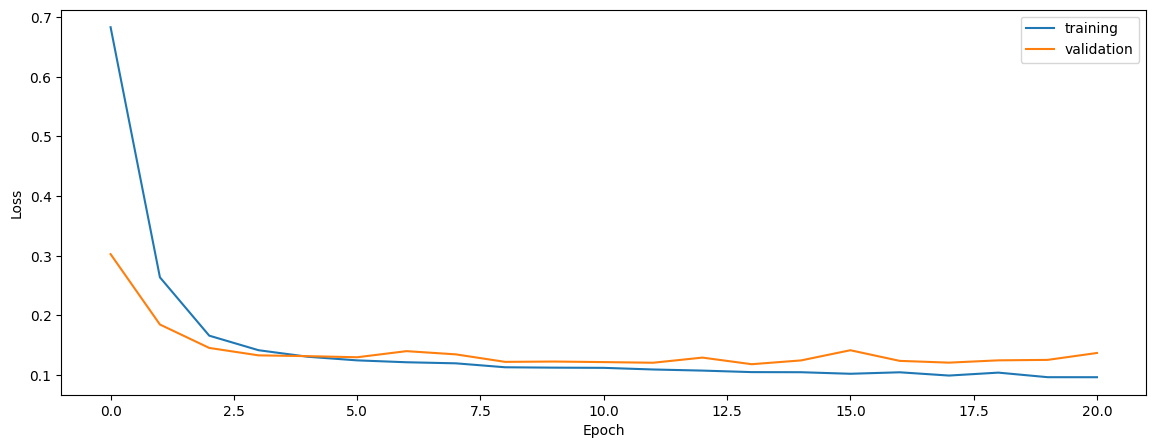

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.9589612974128969
0.9557348908287802
0.9585638569900972


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

native
0.9587040069139879
0.9547773356435805
0.9587904811545775


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.9579827369189808
0.9594109708342495
0.9590085152740331


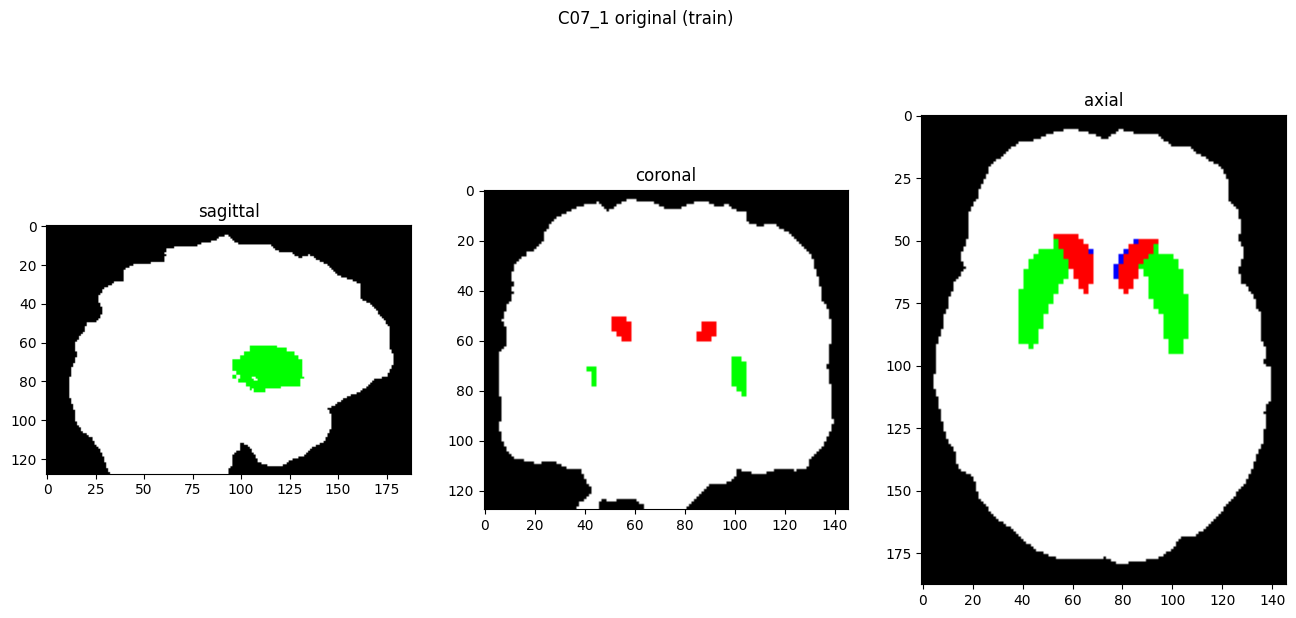

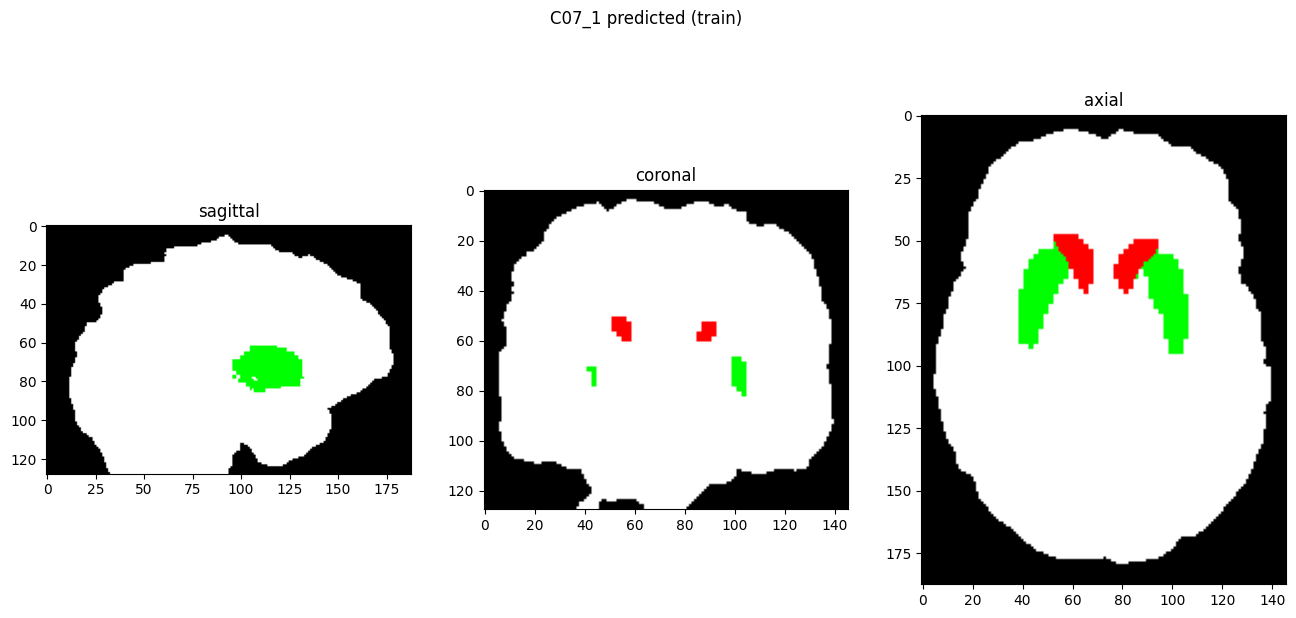

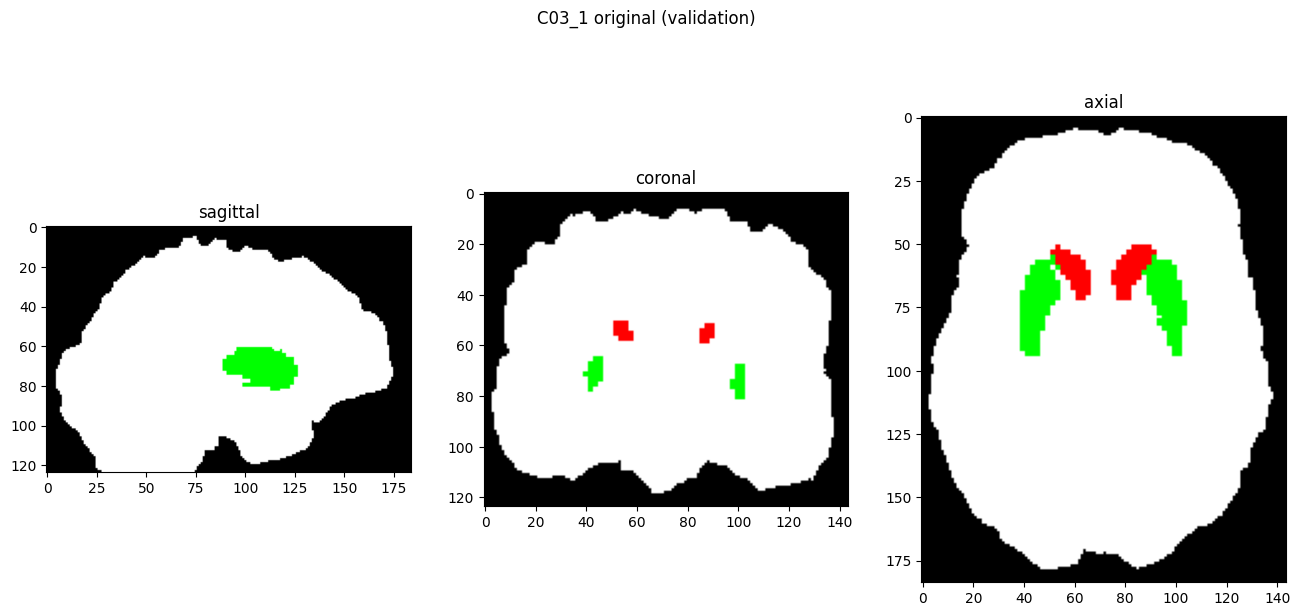

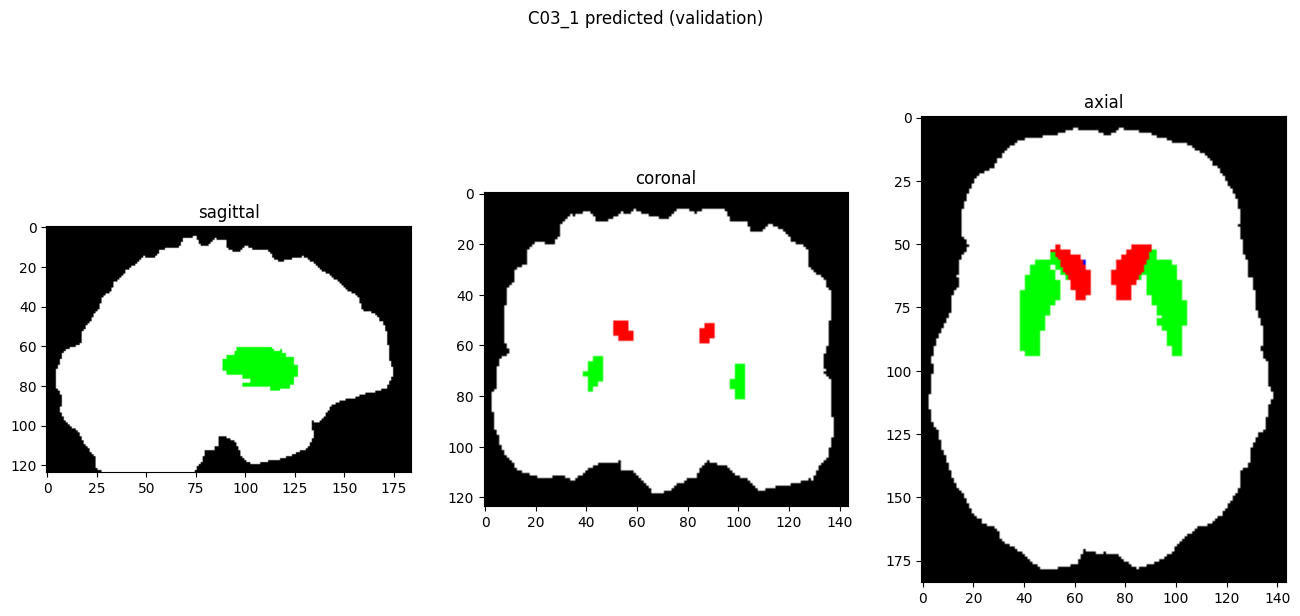

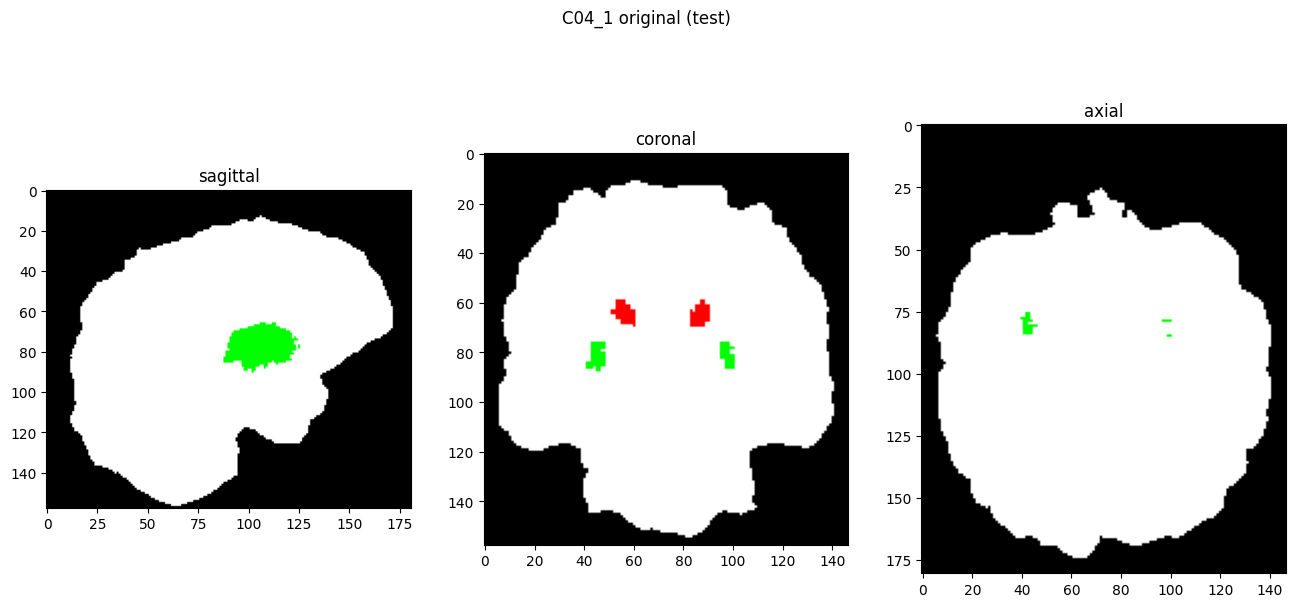

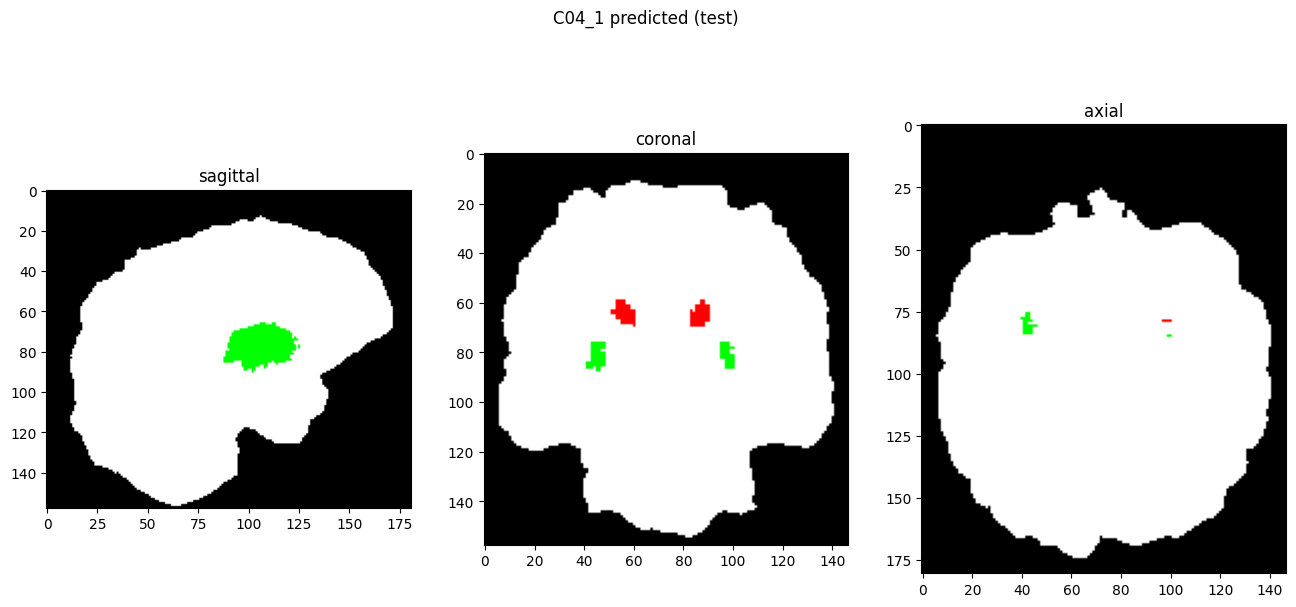

In [10]:
showResults(model, gen, threshold=0)